# Error propagation contour plots

#### Load needed packages

In [27]:
import rpy2

# necessary to workaround the error: /u01/anaconda2/lib/libreadline.so.6: undefined symbol: PC
# https://www.rittmanmead.com/blog/2016/07/using-r-jupyter-notebooks-big-data-discovery/
import readline

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [28]:
%%R
#libraries previously installed using:
library(seacarb)
library(oce)
library(gsw)

#library(Hmisc)   #for minor ticks in plot

packageVersion('seacarb')

[1] ‘3.1.1’


## 1. Get routines and specify input vars

### 1.1 Read in needed subroutines

In [29]:
%%R
#branch buffesm1 of seacarb-git
source("/homel/cnangini/PROJECTS/seacarb-git/R/errhalf.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errmid.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errors.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/derivnum.R")

# source("/homel/orr/Software/R/seacarb-git-orr/R/updateall.R")

### 1.2 Specifiy input variables & errors (non-flag dependant), i.e., except for the input pair

In [30]:
%%R
# Mean surface-ocean conditions
temp  = 18
salt  = 35 
press = 0

Phos = 2.e-6; Sil = 60.e-6
# Phos = 0.0; Sil =0.0

# Other errors - not flag dependant
salt_e = 0.01    #(psu)
temp_e = 0.01   #(C)

Pt_e = 0.1e-6
Sit_e = 4.0e-6

### 1.3 Specify input pair of variables and corresponding input errors

In [31]:
%%R
# Specify flag & corresponding 2 input variables 
flag = 15

# Approximate regional values (picked off of Fig. 3.2 from Orr, 2011)
ALK_socn = 2295e-6
DIC_socn = 2155e-6
temp_socn  = -0.49
salt_socn  = 33.96 

ALK_trop = 2300e-6
DIC_trop = 1960e-6
temp_trop  = 27.01
salt_trop  = 34.92

# Specify errors
  ALK_e <- seq(0., 20., 1.0) * 1e-6
# ALK_e = seq(0., 20., 10.0) * 1e-6
# Economize (for method='mc'): 9 error estimates (in umol/kg)
# ALK_e = c(0, 0.5, 1, 2, 4, 8, 12, 16, 20) * 1e-6
  DIC_e <- ALK_e

  var1_e <- ALK_e
  var2_e <- DIC_e

  pCO2_e <- seq(0,20,1)
  pH_e   <- seq(0,0.03,0.0015)

### 1.4 Compute derived carbonate system vars with std seacarb routine `carb`:

In [32]:
%%R
# Compute derived carbonate system variables with standard seacarb routine 'carb':

# Southern Ocean
vars_socn <- carb  (flag=15, var1=ALK_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Tropics
vars_trop <- carb  (flag=15, var1=ALK_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

pH_socn <- vars_socn$pH
pH_trop <- vars_trop$pH

pCO2_socn <- vars_socn$pCO2
pCO2_trop <- vars_trop$pCO2

# Compute H+ based on pH definition (ph = -log10[H+], where [H+] is the hydrogen ion concentration in mol/kg
H = 10^(-1*vars_socn$pH)

# Keep only key columns to be consistent with output from 'errors.R' routine (called below)
vars_socn <- data.frame(H, vars_socn[,c('pH','CO2','fCO2','pCO2','HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_socn
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
#numerrs <- length(dat$Var1)
numerrs <- length(ALK_e)
vars_socn <- vars_socn[rep(row.names(vars_socn), numerrs), ]
#nrow(vars_socn)

#Do the same for the tropics
H = 10^(-1*vars_trop$pH)
vars_trop <- data.frame(H, vars_trop[,c('pH', 'CO2','fCO2','pCO2', 'HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_trop
vars_trop <- vars_trop[rep(row.names(vars_trop), numerrs), ]
#nrow(vars_trop)

### 1.5 Use error vectors to build 2x2 error arrays, one for each input pair 

#### Make error arrays (2x2)

In [33]:
%%R
  dat <- expand.grid(DIC_e, ALK_e)

  dat_pHAt   <- expand.grid(pH_e,  ALK_e)
  dat_pHCt   <- expand.grid(pH_e,  DIC_e)
  dat_AtCt   <- expand.grid(DIC_e, ALK_e)
  dat_pCO2pH <- expand.grid(pCO2_e,  pH_e)
  dat_pCO2At <- expand.grid(pCO2_e,  ALK_e)
  dat_pCO2Ct <- expand.grid(pCO2_e,  DIC_e)

# For later use of input pH error combined with other computed errors for At, Ct, pCO2
# Use identity: -log(10) dpH = dH/H 
  H_e <- abs(-log(10) * pH_e * vars_socn$H[1])

  dat_pHpH   <- expand.grid(pH_e,  pH_e)
  dat_HH   <- expand.grid(H_e,  H_e)

In [34]:
%%R
dat

       Var1    Var2
1   0.0e+00 0.0e+00
2   1.0e-06 0.0e+00
3   2.0e-06 0.0e+00
4   3.0e-06 0.0e+00
5   4.0e-06 0.0e+00
6   5.0e-06 0.0e+00
7   6.0e-06 0.0e+00
8   7.0e-06 0.0e+00
9   8.0e-06 0.0e+00
10  9.0e-06 0.0e+00
11  1.0e-05 0.0e+00
12  1.1e-05 0.0e+00
13  1.2e-05 0.0e+00
14  1.3e-05 0.0e+00
15  1.4e-05 0.0e+00
16  1.5e-05 0.0e+00
17  1.6e-05 0.0e+00
18  1.7e-05 0.0e+00
19  1.8e-05 0.0e+00
20  1.9e-05 0.0e+00
21  2.0e-05 0.0e+00
22  0.0e+00 1.0e-06
23  1.0e-06 1.0e-06
24  2.0e-06 1.0e-06
25  3.0e-06 1.0e-06
26  4.0e-06 1.0e-06
27  5.0e-06 1.0e-06
28  6.0e-06 1.0e-06
29  7.0e-06 1.0e-06
30  8.0e-06 1.0e-06
31  9.0e-06 1.0e-06
32  1.0e-05 1.0e-06
33  1.1e-05 1.0e-06
34  1.2e-05 1.0e-06
35  1.3e-05 1.0e-06
36  1.4e-05 1.0e-06
37  1.5e-05 1.0e-06
38  1.6e-05 1.0e-06
39  1.7e-05 1.0e-06
40  1.8e-05 1.0e-06
41  1.9e-05 1.0e-06
42  2.0e-05 1.0e-06
43  0.0e+00 2.0e-06
44  1.0e-06 2.0e-06
45  2.0e-06 2.0e-06
46  3.0e-06 2.0e-06
47  4.0e-06 2.0e-06
48  5.0e-06 2.0e-06
49  6.0e-06 2.0e-06


### 1.6 Specify state-of-art (soa) errors for vars: see error-propagation manuscript (Orr et al. 2017, Table 1) 

These will be plotted as crosses on the error-space diagrams

In [35]:
%%R
ALK_e_soa   <- 2 #umol/kg
DIC_e_soa   <- 2 #umol/kg
pCO2_e_soa  <- 2 #umol/kg
pH_e_soa    <- c(0.003, 0.01)  #total scale

pH_e_soa2   <- pH_e_soa
ALK_e_soa2  <- c(ALK_e_soa, ALK_e_soa)
DIC_e_soa2  <- c(DIC_e_soa, DIC_e_soa)
pCO2_e_soa2 <- c(pCO2_e_soa, pCO2_e_soa)

ALK_e_soa2
DIC_e_soa2
pCO2_e_soa2
pH_e_soa2

[1] 0.003 0.010


## 2. Compute output variables in normal way (with carb)

#### 2.1 At-Ct pair

In [36]:
%%R
vars_socn <- carb  (flag=15, var1=ALK_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

vars_trop <- carb  (flag=15, var1=ALK_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

pH_socn <- vars_socn$pH
pH_trop <- vars_trop$pH

pCO2_socn <- vars_socn$pCO2
pCO2_trop <- vars_trop$pCO2

# Compute H+
H = 10^(-1*vars_socn$pH)

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
vars_socn <- data.frame(H, vars_socn[,c('pH','CO2','fCO2','pCO2','HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_socn
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
numerrs <- length(dat$Var1)
#numerrs
vars_socn <- vars_socn[rep(row.names(vars_socn), numerrs), ]
#nrow(vars_socn)

#Do the same for the tropics
H = 10^(-1*vars_trop$pH)
vars_trop <- data.frame(H, vars_trop[,c('pH', 'CO2','fCO2','pCO2', 'HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_trop
vars_trop <- vars_trop[rep(row.names(vars_trop), numerrs), ]
#nrow(vars_trop)

#### 2.2 pH-At pair

In [37]:
%%R

 vars_pHAt_socn <- carb  (flag=8, var1=pH_socn, ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pHAt_trop <- carb  (flag=8, var1=pH_trop, ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  pH_pHAt_socn <- vars_pHAt_socn$pH
  pH_pHAt_trop <- vars_pHAt_trop$pH
  ALK_pHAt_socn <- vars_pHAt_socn$ALK
  ALK_pHAt_trop <- vars_pHAt_trop$ALK

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pHAt_socn <- data.frame(vars_pHAt_socn[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'DIC', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHAt_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pHAt$Var1)
  vars_pHAt_socn <- vars_pHAt_socn[rep(row.names(vars_pHAt_socn), numerrs), ]
# nrow(vars_socn)

# Do the same for the tropics
  vars_pHAt_trop <- data.frame(vars_pHAt_trop[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'DIC', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHAt_trop
  vars_pHAt_trop <- vars_pHAt_trop[rep(row.names(vars_pHAt_trop), numerrs), ]

#### 2.3 pH-Ct pair

In [38]:
%%R
  vars_pHCt_socn <- carb  (flag=9, var1=pH_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pHCt_trop <- carb  (flag=9, var1=pH_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
 
  pH_pHCt_socn <- vars_pHCt_socn$pH
  pH_pHCt_trop <- vars_pHCt_trop$pH
  DIC_pHCt_socn <- vars_pHCt_socn$DIC
  DIC_pHCt_trop <- vars_pHCt_trop$DIC

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pHCt_socn <- data.frame(vars_pHCt_socn[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'ALK', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHCt_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pHCt$Var1)
  vars_pHCt_socn <- vars_pHCt_socn[rep(row.names(vars_pHCt_socn), numerrs), ]

# Do the same for the tropics
  vars_pHCt_trop <- data.frame(vars_pHCt_trop[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'ALK', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHCt_trop
  vars_pHCt_trop <- vars_pHCt_trop[rep(row.names(vars_pHCt_trop), numerrs), ]

#### 2.4 pCO2-pH pair

In [39]:
%%R
  vars_pCO2pH_socn <- carb  (flag=21, var1=pCO2_socn, pH_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pCO2pH_trop <- carb  (flag=21, var1=pCO2_trop, pH_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  pCO2_pCO2pH_socn <- vars_pCO2pH_socn$pCO2
  pCO2_pCO2pH_trop <- vars_pCO2pH_trop$pCO2
  pH_pCO2pH_socn <- vars_pCO2pH_socn$pH
  pH_pCO2pH_trop <- vars_pCO2pH_trop$pH

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pCO2pH_socn <- data.frame(vars_pCO2pH_socn[,c('CO2','fCO2','HCO3','CO3',
                                          'DIC', 'ALK', 'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2pH_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pCO2pH$Var1)
  vars_pCO2pH_socn <- vars_pCO2pH_socn[rep(row.names(vars_pCO2pH_socn), numerrs), ]

# Do the same for the tropics
  vars_pCO2pH_trop <- data.frame(vars_pCO2pH_trop[,c('CO2','fCO2','HCO3','CO3',
                                               'DIC', 'ALK', 'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2pH_trop
  vars_pCO2pH_trop <- vars_pCO2pH_trop[rep(row.names(vars_pCO2pH_trop), numerrs), ]

#### 2.5 pCO2-At pair

In [40]:
%%R
  vars_pCO2At_socn <- carb  (flag=24, var1=pCO2_socn, ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pCO2At_trop <- carb  (flag=24, var1=pCO2_trop, ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  pCO2_pCO2At_socn <- vars_pCO2At_socn$pCO2
  pCO2_pCO2At_trop <- vars_pCO2At_trop$pCO2
  ALK_pCO2At_socn <- vars_pCO2At_socn$ALK
  ALK_pCO2At_trop <- vars_pCO2At_trop$ALK

  H = 10^(-1*vars_pCO2At_socn$pH)
# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pCO2At_socn <- data.frame(H, vars_pCO2At_socn[,c('pH','CO2','fCO2','HCO3','CO3','DIC',
                                                        'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2At_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pCO2At$Var1)
  vars_pCO2At_socn <- vars_pCO2At_socn[rep(row.names(vars_pCO2At_socn), numerrs), ]

# Do the same for the tropics
  H = 10^(-1*vars_pCO2At_trop$pH)
  vars_pCO2At_trop <- data.frame(H, vars_pCO2At_trop[,c('pH','CO2','fCO2','HCO3','CO3','DIC',
                                                     'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2At_trop
  vars_pCO2At_trop <- vars_pCO2At_trop[rep(row.names(vars_pCO2At_trop), numerrs), ]

#### 2.6 pCO2-Ct pair

In [41]:
%%R
  vars_pCO2Ct_socn <- carb  (flag=25, var1=pCO2_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pCO2Ct_trop <- carb  (flag=25, var1=pCO2_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
 
  pCO2_pCO2Ct_socn <- vars_pCO2Ct_socn$pCO2
  pCO2_pCO2Ct_trop <- vars_pCO2Ct_trop$pCO2
  DIC_pCO2Ct_socn <- vars_pCO2Ct_socn$DIC
  DIC_pCO2Ct_trop <- vars_pCO2Ct_trop$DIC

  H = 10^(-1*vars_pCO2Ct_socn$pH)
# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pCO2Ct_socn <- data.frame(H, vars_pCO2Ct_socn[,c('pH','CO2','fCO2','HCO3','CO3','ALK',
                                                        'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2Ct_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pCO2Ct$Var1)
  vars_pCO2Ct_socn <- vars_pCO2Ct_socn[rep(row.names(vars_pCO2Ct_socn), numerrs), ]

# Do the same for the tropics
  H = 10^(-1*vars_pCO2Ct_trop$pH)
  vars_pCO2Ct_trop <- data.frame(H, vars_pCO2Ct_trop[,c('pH','CO2','fCO2','HCO3','CO3','ALK',
                                                     'OmegaAragonite','OmegaCalcite')] )
  vars_pCO2Ct_trop
  vars_pCO2Ct_trop <- vars_pCO2Ct_trop[rep(row.names(vars_pCO2Ct_trop), numerrs), ]

## 3. Propagate errors

### 3.1 MEASUREMENT error only, i.e., ignore errors in equilibrium constants (K's)

The cell just below is for demonstration; it could be deleteted because it's results are not used.

In [42]:
%%R
# Absolute error (Measurements only)
# ----------------------------------
# SOUTHERN OCEAN:
#Consider errors only in 'var1' and 'var2': other errors (T, S, Pt, Sit) are neglilgible
absEm_socn <- errors  (flag, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat$Var2, evar2=dat$Var1, 
              eS=0, eT=0, ePt=0, eSit=0, epK=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Relative error (in percent)
relEm_socn <- 100* absEm_socn / vars_socn
#relEm_socn

# TROPICS:
#Consider errors only in 'var1' and 'var2': other errors (T, S, Pt, Sit) are neglilgible
absEm_trop <- errors  (flag, var1=ALK_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat$Var2, evar2=dat$Var1, 
              eS=0, eT=0, ePt=0, eSit=0, epK=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Relative error (in percent)
#cat('Relative error (Tropics, in percent):\n')
relEm_trop <- 100* absEm_trop / vars_trop
#relEm_trop

### 3.2   K errors only (use default errors for K's)

In [43]:
%%R 
absEk_socn <- errors  (flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                       Patm=1, P=press, Pt=Phos, Sit=Sil, 
                       evar1=dat$Var2*0, evar2=dat$Var1*0, 
                       eS=0, eT=0, ePt=0, eSit=0, 
                       k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Relative error (in percent)
relEk_socn <- 100* absEk_socn / vars_socn

absEk_trop <- errors  (flag=15, var1=ALK_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, 
                       Patm=1, P=press, Pt=Phos, Sit=Sil, 
                       evar1=dat$Var2*0, evar2=dat$Var1*0, 
                       eS=0, eT=0, ePt=0, eSit=0, 
                       k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Relative error (in percent)
relEk_trop <- 100* absEk_trop / vars_trop

### 3.3 TOTAL errors (with default errors for K's)

In [44]:
%%R
errors (flag=15, var1=c(2300,2350)*1e-6, var2=c(2000,2000)*1e-6, S=salt, T=temp, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=2, evar2=2, eS=0, eT=0, ePt=0, eSit=0,
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')

             H       pH        CO2    fCO2    pCO2     HCO3      CO3
1 7.554067e-05 4642.196 0.12989698 3788453 3801681 3.404424 1.841943
2 5.757605e-05 4194.502 0.09939266 2898792 2908913 3.465426 1.879081
  OmegaAragonite OmegaCalcite
1       28445.47     43988.49
2       29019.00     44875.39


#### 3.3.1 At-Ct pair (flag=21)

In [45]:
%%R
length(dat$Var2)

[1] 441


In [51]:
%%R
# Std estimates for errors in constants in errors.R routine (from Dickson & Riley, 1978; Dickson, 2010)
# epKstd  <- c(0.002, 0.01,  0.02, 0.01,  0.01, 0.02, 0.02)
# Estimates for errors in constants in errors.R routine (from Orr et al., 2017)
  #epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02) #****ORIG****
  
  #FROM SINGLE NOTEBOOK
  epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02, 0.01)
# Low estimates for errors in constants: only random errors for K1 & K2 (Lueker et al., 2000) and Kb (Dickson, 1990))
# epKlow  <- c(0.002, 0.005, 0.01, 0.002, 0.01, 0.02, 0.02)

absEt_socn <- errors (flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=dat$Var2, evar2=dat$Var1, eS=0, eT=0, ePt=0, eSit=0, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_socn <- 100* absEt_socn / vars_socn



# Critical curves
# ===============
# Southern Ocean
errcirc <- errhalf(flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_AtCt_socn   <- data.frame(errcirc[1]) * 1e+6
sig2_AtCt_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_AtCt_socn   <- data.frame(errcirc[3]) 
sig1hp_AtCt_socn <- data.frame(errcirc[4]) * 1e+6
sig2hp_AtCt_socn <- data.frame(errcirc[5]) * 1e+6



#### 3.3.2 pH-At pair (flag=8)

In [52]:
%%R
absEt_pHAt_socn <- errors  (flag=8, var1=pH_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHAt$Var1, evar2=dat_pHAt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pHAt_socn <- 100* absEt_pHAt_socn / vars_pHAt_socn
#absEt_pHAt_socn$pH <- NULL

absEt_pHAt_trop <- errors  (flag=8, var1=pH_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHAt$Var1, evar2=dat_pHAt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pHAt_trop <- 100* absEt_pHAt_trop / vars_pHAt_trop

# Critical curves (pCO2-At pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=8, var1=pH_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHAt_socn   <- data.frame(errcirc[1])
sig2_pHAt_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_pHAt_socn   <- data.frame(errcirc[3])
sig1hp_pHAt_socn <- data.frame(errcirc[4])
sig2hp_pHAt_socn <- data.frame(errcirc[5]) * 1e+6

# Tropics
errcirc <- errhalf(flag=8, var1=pH_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHAt_trop   <- data.frame(errcirc[1])
sig2_pHAt_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_pHAt_trop   <- data.frame(errcirc[3])
sig1hp_pHAt_trop <- data.frame(errcirc[4])
sig2hp_pHAt_trop <- data.frame(errcirc[5]) * 1e+6

#### 3.3.3 pH-Ct pair (flag=9)

In [48]:
absEt_pHCt_socn <- errors  (flag=9, var1=pH_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHCt$Var1, evar2=dat_pHCt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pHCt_socn <- 100* absEt_pHCt_socn / vars_pHCt_socn
#absEt_pCO2At_socn$pH <- NULL

absEt_pHCt_trop <- errors  (flag=9, var1=pH_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHCt$Var1, evar2=dat_pHCt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pHCt_trop <- 100* absEt_pHCt_trop / vars_pHCt_trop

# Critical curves (pCO2-At pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=9, var1=pH_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHCt_socn   <- data.frame(errcirc[1])
sig2_pHCt_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_pHCt_socn   <- data.frame(errcirc[3])
sig1hp_pHCt_socn <- data.frame(errcirc[4])
sig2hp_pHCt_socn <- data.frame(errcirc[5]) * 1e+6

# Tropics
errcirc <- errhalf(flag=9, var1=pH_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHCt_trop   <- data.frame(errcirc[1])
sig2_pHCt_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_pHCt_trop   <- data.frame(errcirc[3])
sig1hp_pHCt_trop <- data.frame(errcirc[4])
sig2hp_pHCt_trop <- data.frame(errcirc[5]) * 1e+6


SyntaxError: invalid syntax (<ipython-input-48-40ab177e4e90>, line 2)

#### 3.3.4 pCO2-pH pair (flag=21)

In [36]:
absEt_pCO2pH_socn <- errors  (flag=21, var1=pCO2_socn, var2=pH_socn, S=salt_socn, T=temp_socn, 
                              Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2pH$Var1, evar2=dat_pCO2pH$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pCO2pH_socn <- 100* absEt_pCO2pH_socn / vars_pCO2pH_socn

absEt_pCO2pH_trop <- errors  (flag=21, var1=pCO2_trop, var2=pH_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2pH$Var1, evar2=dat_pCO2pH$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pCO2pH_trop <- 100* absEt_pCO2pH_trop / vars_pCO2pH_trop

# Critical curves (pCO2-pH pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=21, var1=pCO2_socn, var2=pH_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2pH_socn   <- data.frame(errcirc[1])
sig2_pCO2pH_socn   <- data.frame(errcirc[2])
sigy_pCO2pH_socn   <- data.frame(errcirc[3])
sig1hp_pCO2pH_socn <- data.frame(errcirc[4])
sig2hp_pCO2pH_socn <- data.frame(errcirc[5])

# Tropics
errcirc <- errhalf(flag=21, var1=pCO2_trop, var2=pH_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2pH_trop   <- data.frame(errcirc[1])
sig2_pCO2pH_trop   <- data.frame(errcirc[2])
sigy_pCO2pH_trop   <- data.frame(errcirc[3])
sig1hp_pCO2pH_trop <- data.frame(errcirc[4])
sig2hp_pCO2pH_trop <- data.frame(errcirc[5])



Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:

#### 3.3.5 pCO2-At pair (flag=24)

In [37]:
absEt_pCO2At_socn <- errors  (flag=24, var1=pCO2_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2At$Var1, evar2=dat_pCO2At$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pCO2At_socn <- 100* absEt_pCO2At_socn / vars_pCO2At_socn
#absEt_pCO2At_socn$pH <- NULL

absEt_pCO2At_trop <- errors  (flag=24, var1=pCO2_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2At$Var1, evar2=dat_pCO2At$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pCO2At_trop <- 100* absEt_pCO2At_trop / vars_pCO2At_trop

# Critical curves (pCO2-At pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=24, var1=pCO2_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2At_socn   <- data.frame(errcirc[1])
sig2_pCO2At_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_pCO2At_socn   <- data.frame(errcirc[3])
sig1hp_pCO2At_socn <- data.frame(errcirc[4])
sig2hp_pCO2At_socn <- data.frame(errcirc[5]) * 1e+6

# Tropics
errcirc <- errhalf(flag=24, var1=pCO2_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2At_trop   <- data.frame(errcirc[1])
sig2_pCO2At_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_pCO2At_trop   <- data.frame(errcirc[3])
sig1hp_pCO2At_trop <- data.frame(errcirc[4])
sig2hp_pCO2At_trop <- data.frame(errcirc[5]) * 1e+6



Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:

#### 3.3.6 pCO2-Ct pair (flag=25)

In [38]:
absEt_pCO2Ct_socn <- errors  (flag=25, var1=pCO2_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2At$Var1, evar2=dat_pCO2At$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pCO2Ct_socn <- 100* absEt_pCO2Ct_socn / vars_pCO2Ct_socn
#absEt_pCO2At_socn$pH <- NULL
#vars_pCO2Ct_socn
#absEt_pCO2At_socn

absEt_pCO2Ct_trop <- errors  (flag=25, var1=pCO2_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pCO2At$Var1, evar2=dat_pCO2At$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pCO2Ct_trop <- 100* absEt_pCO2Ct_trop / vars_pCO2Ct_trop

# Critical curves (pCO2-At pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=25, var1=pCO2_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2Ct_socn   <- data.frame(errcirc[1])
sig2_pCO2Ct_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_pCO2Ct_socn   <- data.frame(errcirc[3])
sig1hp_pCO2Ct_socn <- data.frame(errcirc[4])
sig2hp_pCO2Ct_socn <- data.frame(errcirc[5]) * 1e+6

# Tropics
errcirc <- errhalf(flag=25, var1=pCO2_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pCO2Ct_trop   <- data.frame(errcirc[1])
sig2_pCO2Ct_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_pCO2Ct_trop   <- data.frame(errcirc[3])
sig1hp_pCO2Ct_trop <- data.frame(errcirc[4])
sig2hp_pCO2Ct_trop <- data.frame(errcirc[5]) * 1e+6



Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kb(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale, : S and/or T is outside the range of validity of the formulation available for Kb in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kw(S, T, P, pHscale = pHscale, kSWS2scale = kSWS2scale): S and/or T is outside the range of validity of the formulation available for Kw in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:
In seacarb::Kspa(S, T, P): S and/or T is outside the range of validity of the formulation available for Kspa in seacarb.Warning message:

### 3.4 Compute midline where both input members contribute equally to overall error

#### Function to strip NaNs and add a 0 at beginning of a vector

In [55]:
%%R
george <- NULL
if (is.null(george)) {aaa <-3}
print(aaa)

[1] 3


In [56]:
%%R
zenon <- function(x){
       # Get rid of NaN's
       x <- c(0.0, x[!is.na(x)]) 
       return(x)
}

#### Compute 'midline' where e1=e2

In [57]:
%%R
sigyspct <- seq(0,20,by=0.1) # in percent

# pH-At pair
# ----------
# Southern Ocean
errm <- errmid(flag=8, var1=pH_socn[1], var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pHAt_socn   <- data.frame(errm[1])
sigm2_pHAt_socn   <- data.frame(errm[2]) * 1e+6


# pH-Ct pair
# ----------
# Southern Ocean
errm <- errmid(flag=9, var1=pH_socn[1], var=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pHCt_socn   <- data.frame(errm[1])
sigm2_pHCt_socn   <- data.frame(errm[2]) * 1e+6


# At-Ct pair
# ----------
# Southern Ocean
errm <- errmid(flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_AtCt_socn   <- data.frame(errm[1]) * 1e+6
sigm2_AtCt_socn   <- data.frame(errm[2]) * 1e+6


# pCO2-pH pair
# ----------
# Southern Ocean
errm <- errmid(flag=21, var1=pCO2_socn[1], var2=pH_socn[1], S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pCO2pH_socn   <- data.frame(errm[1])
sigm2_pCO2pH_socn   <- data.frame(errm[2]) 

# pCO2-At pair
# ----------
# Southern Ocean
errm <- errmid(flag=24, var1=pCO2_socn[1], var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pCO2At_socn   <- data.frame(errm[1])
sigm2_pCO2At_socn   <- data.frame(errm[2]) * 1e+6


# pCO2-Ct pair
# ----------
# Southern Ocean
errm <- errmid(flag=25, var1=pCO2_socn[1], var=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pCO2Ct_socn   <- data.frame(errm[1])
sigm2_pCO2Ct_socn   <- data.frame(errm[2]) * 1e+6



## 4. Plot results: contours of calculated errors from input errors

### 4.1 Create file 'prettyaxes.R' to beautify subsequent plots (call it in cell below)

In [58]:
cat(' box()\n',
    'axis(1,labels=FALSE, tcl=-0.35) ; axis(1, lwd=0, line=-0.4, labels=TRUE)\n',
    'axis(2,labels=FALSE,tcl=-0.35)  ; axis(2, lwd=0, line=-0.4, las=2, labels=TRUE)\n',
    'axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)\n',
   file='prettyaxes.R')

NameError: name 'cat' is not defined

### 4.2 Define simpler labels of variables to plot

#### 4.2.1 For CO3 for all pairs and a few other variables (for At-Ct pair)

In [60]:
%%R
#   Absolute changes:
    pHsocn <- absEt_socn$pH
    pHtrop <- absEt_trop$pH

    pCO2socn <- absEt_socn$pCO2
    pCO2trop <- absEt_trop$pCO2

#   for CO3:
#   --------
    CO3socn <- absEt_socn$CO3
    CO3trop <- absEt_trop$CO3

    CO3_pCO2pH_socn <- absEt_pCO2pH_socn$CO3
    CO3_pCO2pH_trop <- absEt_pCO2pH_trop$CO3

    CO3_pHAt_socn <- absEt_pHAt_socn$CO3
    CO3_pHAt_trop <- absEt_pHAt_trop$CO3

    CO3_pHCt_socn <- absEt_pHCt_socn$CO3
    CO3_pHCt_trop <- absEt_pHCt_trop$CO3

    CO3_pCO2At_socn <- absEt_pCO2At_socn$CO3
    CO3_pCO2At_trop <- absEt_pCO2At_trop$CO3

    CO3_pCO2Ct_socn <- absEt_pCO2Ct_socn$CO3
    CO3_pCO2Ct_trop <- absEt_pCO2Ct_trop$CO3

#   relative errors
    rCO3_pCO2pH_socn <- relEt_pCO2pH_socn$CO3
    rCO3_pCO2pH_trop <- relEt_pCO2pH_trop$CO3

    rCO3_pHAt_socn <- relEt_pHAt_socn$CO3
    rCO3_pHAt_trop <- relEt_pHAt_trop$CO3

    rCO3_pHCt_socn <- relEt_pHCt_socn$CO3
    rCO3_pHCt_trop <- relEt_pHCt_trop$CO3

    rCO3_pCO2At_socn <- relEt_pCO2At_socn$CO3
    rCO3_pCO2At_trop <- relEt_pCO2At_trop$CO3

    rCO3_pCO2Ct_socn <- relEt_pCO2Ct_socn$CO3
    rCO3_pCO2Ct_trop <- relEt_pCO2Ct_trop$CO3


#   Relative changes:
    rCO3socn <- relEt_socn$CO3
    rCO3trop <- relEt_trop$CO3

    rHsocn   <- relEt_socn$H
    rHtrop   <- relEt_trop$H

    rpCO2socn   <- relEt_socn$pCO2
    rpCO2trop   <- relEt_trop$pCO2


Error in withVisible({ : objet 'absEt_pCO2pH_socn' introuvable


/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in withVisible({ : objet 'absEt_pCO2pH_socn' introuvable

  warnings.warn(x, RRuntimeWarning)
/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: There were 50 or more warnings (use warnings() to see the first 50)
  warnings.warn(x, RRuntimeWarning)


#### 4.2.2 Same thing for CO2*

In [44]:
#   for CO2:
#   --------
#   Absolute changes:
    CO2socn <- absEt_socn$CO2
    CO2trop <- absEt_trop$CO2

    CO2_pCO2pH_socn <- absEt_pCO2pH_socn$CO2
    CO2_pCO2pH_trop <- absEt_pCO2pH_trop$CO2

    CO2_pHAt_socn <- absEt_pHAt_socn$CO2
    CO2_pHAt_trop <- absEt_pHAt_trop$CO2

    CO2_pHCt_socn <- absEt_pHCt_socn$CO2
    CO2_pHCt_trop <- absEt_pHCt_trop$CO2

    CO2_pCO2At_socn <- absEt_pCO2At_socn$CO2
    CO2_pCO2At_trop <- absEt_pCO2At_trop$CO2

    CO2_pCO2Ct_socn <- absEt_pCO2Ct_socn$CO2
    CO2_pCO2Ct_trop <- absEt_pCO2Ct_trop$CO2

#   Relative errors
    rCO2socn <- relEt_socn$CO2
    rCO2trop <- relEt_trop$CO2

    rCO2_pCO2pH_socn <- relEt_pCO2pH_socn$CO2
    rCO2_pCO2pH_trop <- relEt_pCO2pH_trop$CO2

    rCO2_pHAt_socn <- relEt_pHAt_socn$CO2
    rCO2_pHAt_trop <- relEt_pHAt_trop$CO2

    rCO2_pHCt_socn <- relEt_pHCt_socn$CO2
    rCO2_pHCt_trop <- relEt_pHCt_trop$CO2

    rCO2_pCO2At_socn <- relEt_pCO2At_socn$CO2
    rCO2_pCO2At_trop <- relEt_pCO2At_trop$CO2

    rCO2_pCO2Ct_socn <- relEt_pCO2Ct_socn$CO2
    rCO2_pCO2Ct_trop <- relEt_pCO2Ct_trop$CO2

#### 4.2.3 Same thing for pCO2

In [45]:
#   for CO2:
#   --------
#   Absolute changes:
    pCO2socn <- absEt_socn$pCO2
    pCO2trop <- absEt_trop$pCO2

    pCO2_pCO2pH_socn <- absEt_pCO2pH_socn$pCO2
    pCO2_pCO2pH_trop <- absEt_pCO2pH_trop$pCO2

    pCO2_pHAt_socn <- absEt_pHAt_socn$pCO2
    pCO2_pHAt_trop <- absEt_pHAt_trop$pCO2

    pCO2_pHCt_socn <- absEt_pHCt_socn$pCO2
    pCO2_pHCt_trop <- absEt_pHCt_trop$pCO2

    pCO2_pCO2At_socn <- absEt_pCO2At_socn$pCO2
    pCO2_pCO2At_trop <- absEt_pCO2At_trop$pCO2

    pCO2_pCO2Ct_socn <- absEt_pCO2Ct_socn$pCO2
    pCO2_pCO2Ct_trop <- absEt_pCO2Ct_trop$pCO2

#   Relative errors
    rpCO2socn <- relEt_socn$pCO2
    rpCO2trop <- relEt_trop$pCO2

    rpCO2_pCO2pH_socn <- relEt_pCO2pH_socn$pCO2
    rpCO2_pCO2pH_trop <- relEt_pCO2pH_trop$pCO2

    rpCO2_pHAt_socn <- relEt_pHAt_socn$pCO2
    rpCO2_pHAt_trop <- relEt_pHAt_trop$pCO2

    rpCO2_pHCt_socn <- relEt_pHCt_socn$pCO2
    rpCO2_pHCt_trop <- relEt_pHCt_trop$pCO2

    rpCO2_pCO2At_socn <- relEt_pCO2At_socn$pCO2
    rpCO2_pCO2At_trop <- relEt_pCO2At_trop$pCO2

    rCO2_pCO2Ct_socn <- relEt_pCO2Ct_socn$CO2
    rCO2_pCO2Ct_trop <- relEt_pCO2Ct_trop$CO2

In [46]:
#rCO2_pCO2pH_socn

#### 4.2.4 Same thing for $\Omega_A$

In [47]:
#   for OmegaA:
#   --------
#   Absolute changes:
    OmegaAsocn <- absEt_socn$OmegaAragonite
    OmegaAtrop <- absEt_trop$CO2

    OmegaA_pCO2pH_socn <- absEt_pCO2pH_socn$OmegaAragonite
    OmegaA_pCO2pH_trop <- absEt_pCO2pH_trop$OmegaAragonite

    OmegaA_pHAt_socn <- absEt_pHAt_socn$OmegaAragonite
    OmegaA_pHAt_trop <- absEt_pHAt_trop$OmegaAragonite

    OmegaA_pHCt_socn <- absEt_pHCt_socn$OmegaAragonite
    OmegaA_pHCt_trop <- absEt_pHCt_trop$OmegaAragonite

    OmegaA_pCO2At_socn <- absEt_pCO2At_socn$OmegaAragonite
    OmegaA_pCO2At_trop <- absEt_pCO2At_trop$OmegaAragonite2

    OmegaA_pCO2Ct_socn <- absEt_pCO2Ct_socn$OmegaAragonite
    OmegaA_pCO2Ct_trop <- absEt_pCO2Ct_trop$OmegaAragonite

#   Relative errors
    rOmegaAsocn <- relEt_socn$OmegaAragonite
    rOmegaAtrop <- relEt_trop$OmegaAragonite

    rOmegaA_pCO2pH_socn <- relEt_pCO2pH_socn$OmegaAragonite
    rOmegaA_pCO2pH_trop <- relEt_pCO2pH_trop$OmegaAragonite

    rOmegaA_pHAt_socn <- relEt_pHAt_socn$OmegaAragonite
    rOmegaA_pHAt_trop <- relEt_pHAt_trop$OmegaAragonite

    rOmegaA_pHCt_socn <- relEt_pHCt_socn$OmegaAragonite
    rOmegaA_pHCt_trop <- relEt_pHCt_trop$OmegaAragonite

    rOmegaA_pCO2At_socn <- relEt_pCO2At_socn$OmegaAragonite
    rOmegaA_pCO2At_trop <- relEt_pCO2At_trop$OmegaAragonite

    rOmegaA_pCO2Ct_socn <- relEt_pCO2Ct_socn$OmegaAragonite
    rOmegaA_pCO2Ct_trop <- relEt_pCO2Ct_trop$OmegaAragonite

#### 4.2.5 Same thing for HCO3-

In [48]:
#   for HCO3:
#   --------
#   Absolute changes:
    HCO3socn <- absEt_socn$HCO3
    HCO3trop <- absEt_trop$HCO3

    HCO3_pCO2pH_socn <- absEt_pCO2pH_socn$HCO3
    HCO3_pCO2pH_trop <- absEt_pCO2pH_trop$HCO3

    HCO3_pHAt_socn <- absEt_pHAt_socn$HCO3
    HCO3_pHAt_trop <- absEt_pHAt_trop$HCO3

    HCO3_pHCt_socn <- absEt_pHCt_socn$HCO3
    HCO3_pHCt_trop <- absEt_pHCt_trop$HCO3

    HCO3_pCO2At_socn <- absEt_pCO2At_socn$HCO3
    HCO3_pCO2At_trop <- absEt_pCO2At_trop$HCO3

    HCO3_pCO2Ct_socn <- absEt_pCO2Ct_socn$HCO3
    HCO3_pCO2Ct_trop <- absEt_pCO2Ct_trop$HCO3

#   Relative changes:
    rHCO3socn <- relEt_socn$HCO3
    rHCO3trop <- relEt_trop$HCO3

    rHCO3_pCO2pH_socn <- relEt_pCO2pH_socn$HCO3
    rHCO3_pCO2pH_trop <- relEt_pCO2pH_trop$HCO3

    rHCO3_pHAt_socn <- relEt_pHAt_socn$HCO3
    rHCO3_pHAt_trop <- relEt_pHAt_trop$HCO3

    rHCO3_pHCt_socn <- relEt_pHCt_socn$HCO3
    rHCO3_pHCt_trop <- relEt_pHCt_trop$HCO3

    rHCO3_pCO2At_socn <- relEt_pCO2At_socn$HCO3
    rHCO3_pCO2At_trop <- relEt_pCO2At_trop$HCO3

    rHCO3_pCO2Ct_socn <- relEt_pCO2Ct_socn$HCO3
    rHCO3_pCO2Ct_trop <- relEt_pCO2Ct_trop$HCO3

#### 4.2.6 Almost Same thing for H+

In [49]:
#   for HCO3:
#   --------
#   Absolute changes:
    Hsocn <- absEt_socn$H
    Htrop <- absEt_trop$H

    H_pCO2At_socn <- absEt_pCO2At_socn$H
    H_pCO2At_trop <- absEt_pCO2At_trop$H

    H_pCO2Ct_socn <- absEt_pCO2Ct_socn$H
    H_pCO2Ct_trop <- absEt_pCO2Ct_trop$H

    H_pCO2pH_socn <- dat_HH$Var2
    H_pCO2pH_trop <- dat_HH$Var2

    H_pHAt_socn <- dat_HH$Var1
    H_pHAt_trop <- dat_HH$Var1

    H_pHCt_socn <- dat_HH$Var1
    H_pHCt_trop <- dat_HH$Var1

#   Relative changes:
    rHsocn <- relEt_socn$H
    rHtrop <- relEt_trop$H

    rH_pCO2At_socn <- relEt_pCO2At_socn$H
    rH_pCO2At_trop <- relEt_pCO2At_trop$H

    rH_pCO2Ct_socn <- relEt_pCO2Ct_socn$H
    rH_pCO2Ct_trop <- relEt_pCO2Ct_trop$H

    rH_pCO2pH_socn <- 100*H_pCO2pH_socn / vars_socn$H[1]
    rH_pCO2pH_trop <- 100*H_pCO2pH_trop / vars_trop$H[1]

    rH_pHAt_socn <- 100*H_pHAt_socn / vars_socn$H[1]
    rH_pHAt_trop <- 100*H_pHAt_trop / vars_trop$H[1]

    rH_pHCt_socn <- 100*H_pHCt_socn / vars_socn$H[1]
    rH_pHCt_trop <- 100*H_pHCt_trop / vars_trop$H[1]

#### 4.2.7 HCO3- / H+ (SIR): compute from HCO3 and H+ relative errors

In [50]:
    rHCO3Hsocn <- sqrt(rHCO3socn^2 + rHsocn^2)
    rHCO3Htrop <- sqrt(rHCO3trop^3 + rHtrop^2)

    rHCO3H_pCO2At_socn <- sqrt(rHCO3_pCO2At_socn^2 + rH_pCO2At_socn^2)
    rHCO3H_pCO2At_trop <- sqrt(rHCO3_pCO2At_trop^2 + rH_pCO2At_trop^2)

    rHCO3H_pCO2Ct_socn <- sqrt(rHCO3_pCO2Ct_socn^2 + rH_pCO2Ct_socn^2)
    rHCO3H_pCO2Ct_trop <- sqrt(rHCO3_pCO2Ct_trop^2 + rH_pCO2Ct_trop^2)

    rHCO3H_pCO2pH_socn <- sqrt(rHCO3_pCO2pH_socn^2 + rH_pCO2pH_socn^2)
    rHCO3H_pCO2pH_trop <- sqrt(rHCO3_pCO2pH_trop^2 + rH_pCO2pH_trop^2)

    rHCO3H_pHAt_socn   <- sqrt(rHCO3_pHAt_socn^2 + rH_pHAt_socn^2)
    rHCO3H_pHAt_trop   <- sqrt(rHCO3_pHAt_trop^2 + rH_pHAt_trop^2)

    rHCO3H_pHCt_socn   <- sqrt(rHCO3_pHCt_socn^2 + rH_pHCt_socn^2)
    rHCO3H_pHCt_trop   <- sqrt(rHCO3_pHCt_trop^2 + rH_pHCt_trop^2)

### 4.3 Plot results

#### 4.3.1 Plot function

In [51]:
plterrcontour <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb, 
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
    points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)


#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

In [52]:
plterrcontourB <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sigsoaX, sigsoaY,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
    points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
    points(sigsoaX, sigsoaY, col="black", cex=1.7, pch=4)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)

#   Add 2 colored text strings near origin to indicate the propagated error at the origin (from constants only)
    a0 <- za[1,1]
    b0 <- zb[1,1]
    if (a0 < 1) {ndiga <- 2} else {ndiga <- 3}
    if (b0 < 1) {ndigb <- 2} else {ndigb <- 3}
    mtext( format(a0, digits=ndiga), side=1, line=2.5, at=0, srt=0,  cex=1.05, col='blue')
    mtext( format(b0, digits=ndigb), side=2, line=1.5, at=0, srt=90, cex=1.05, col='red')

#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

In [53]:
plterrcontourP <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sighpXa, sighpYa,
                           sighpXb, sighpYb,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
    points(sighpXb, sighpYb, col="black", cex=1.7, pch=1)
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)


#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

In [54]:
plterrcontourQ <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sighpXa, sighpYa,
                           sighpXb, sighpYb,
                           sigmidXa, sigmidYa,
                           sigmidXb, sigmidYb,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    if ( is.null(sighpXa) ) {
        points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
        points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
    } else {
        points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
        points(sighpXb, sighpYb, col="black", cex=1.7, pch=1)
    }    
#   Plot mid-line (where e1 = e2 on each isoline [and between isolines])
    lines(sigmidXa, sigmidYa, col="black", lwd=1, lty='solid')
    lines(sigmidXb, sigmidYb, col="black", lwd=1, lty='dashed')
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)


#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

In [55]:
plterrcontourR <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sighpXa, sighpYa,
                           sighpXb, sighpYb,
                           sigmidXa, sigmidYa,
                           sigmidXb, sigmidYb,
                           sigsoaX, sigsoaY,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    if ( is.null(sighpXa) ) {
        points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
        points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
    } else {
        points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
        points(sighpXb, sighpYb, col="black", cex=1.7, pch=1)
    }    
#   Plot mid-line (where e1 = e2 on each isoline [and between isolines])
    lines(sigmidXa, sigmidYa, col="black", lwd=1, lty='solid')
    lines(sigmidXb, sigmidYb, col="black", lwd=1, lty='dashed')
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
#   Plot point(s) at state-of-the-art (soa) for absolute error in each member of the input pair
#   - pH has 2 points (random & overall error); other 3 input variables only have 1 point
    points(sigsoaX, sigsoaY, col="black", cex=1.7, pch=4)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)

#   Add 2 colored text strings near origin to indicate the propagated error at the origin (from constants only)
    a0 <- za[1,1]
    b0 <- zb[1,1]
    if (a0 < 1) {ndiga <- 2} else {ndiga <- 3}
    if (b0 < 1) {ndigb <- 2} else {ndigb <- 3}
    mtext( format(a0, digits=ndiga), side=1, line=2.5, at=0, srt=0,  cex=1.05, col='blue')
    mtext( format(b0, digits=ndigb), side=2, line=1.5, at=0, srt=90, cex=1.05, col='red')

#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

#### 4.3.2 Plot Absolute errors

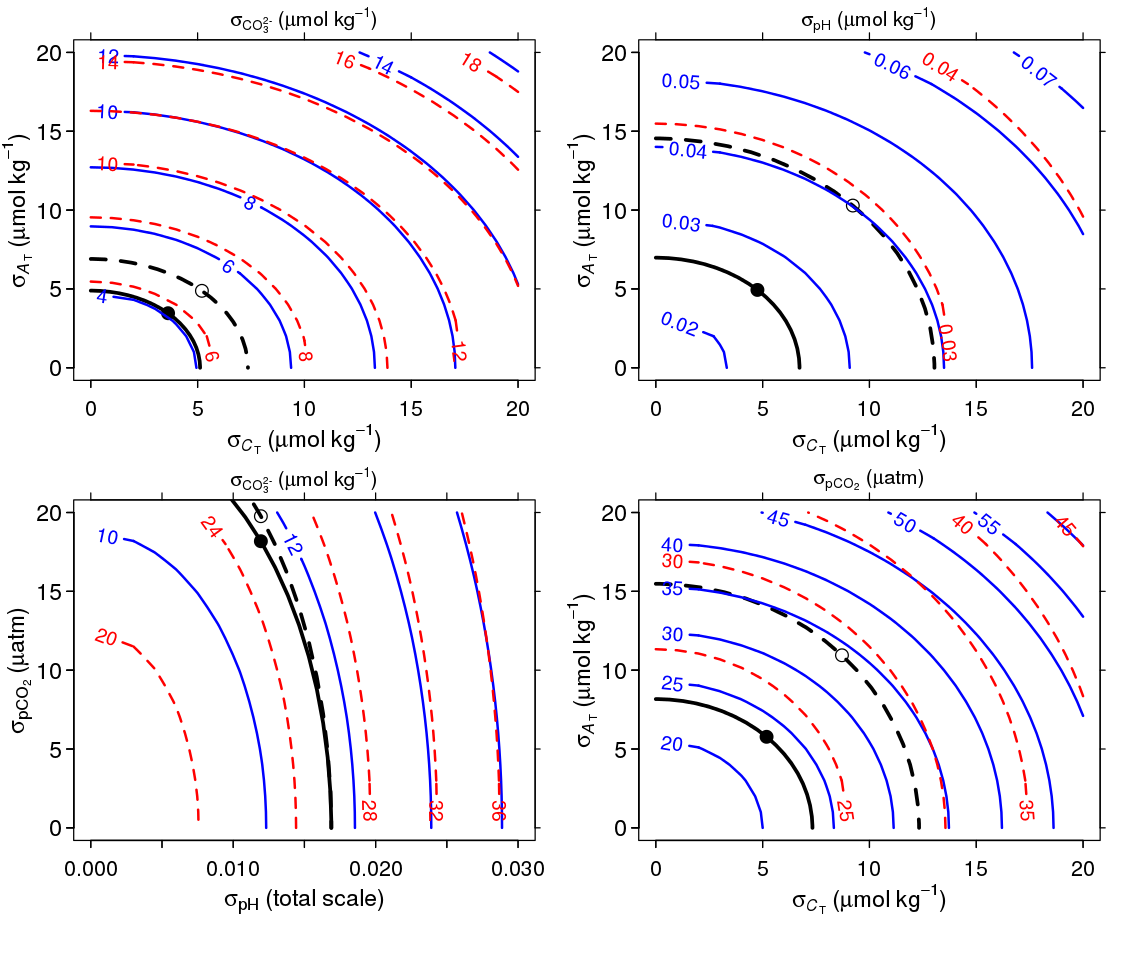

In [56]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="StackedErrors_socn_varsK.pdf",  width=8.5, height=7.0)

  options(repr.plot.width=9.5, repr.plot.height=8)

  par(mfrow=c(2,2), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(CO3socn) <- c(length(DIC_e), length(ALK_e))
    dim(CO3trop) <- c(length(DIC_e), length(ALK_e))

    dim(pHsocn) <- c(length(DIC_e), length(ALK_e))
    dim(pHtrop) <- c(length(DIC_e), length(ALK_e))

    dim(pCO2socn) <- c(length(DIC_e), length(ALK_e))
    dim(pCO2trop) <- c(length(DIC_e), length(ALK_e))


#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
    par(mfrow=c(2,2), mar=c(4,3.7,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))

#   1. CO3 from At & Ct
#   -------------------
    subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO3  ;  sigcritYa <- sig1_AtCt_socn$CO3  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO3  ;  sigcritYb <- sig1_AtCt_trop$CO3
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- CO3socn*1e6  ;  zb <- CO3trop*1e6
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(2,20,by=2)  ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)

#   2. pH from At & Ct
#   -------------------
    subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$pH  ;  sigcritYa <- sig1_AtCt_socn$pH
    sigcritXb <- sig2_AtCt_trop$pH  ;  sigcritYb <- sig1_AtCt_trop$pH
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- pHsocn  ;  zb <- pHtrop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(0.01,0.1,0.01)  ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)

#   3. CO3 from pH-pCO2 pair
#   ------------------------
    dim(CO3_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

    subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$CO3  ;  sigcritYa <- sig1_pCO2pH_socn$CO3
    sigcritXb <- sig2_pCO2pH_trop$CO3  ;  sigcritYb <- sig1_pCO2pH_trop$CO3
    x <- pH_e  ;  y <- pCO2_e
    za <- t(CO3_pCO2pH_socn*1e+6)  ;  zb <- t(CO3_pCO2pH_trop*1e+6)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- seq(0,20,by=2)  ;  levels2 <- seq(0,40,by=4)

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)

#   4. pCO2 from At & Ct
#   -------------------
#   Southern Ocean:
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    subtitle <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")", sep=""))
    sigcritXa <- sig2_AtCt_socn$pCO2  ;  sigcritYa <- sig1_AtCt_socn$pCO2
    sigcritXb <- sig2_AtCt_trop$pCO2  ;  sigcritYb <- sig1_AtCt_trop$pCO2
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- pCO2socn  ;  zb <- pCO2trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(0,60,by=5)  ;  levels2 <- levels1
    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)

# Turn off device driver (to flush output to PDF)
# dev.off()

#### 4.3.3 Plot CO3 for 6 input pairs (1 subplot each)

pH-At: xcrit, ycrit =  0.02144374 99.25529 
pCO2-At: xcrit, ycrit =  18.87566 56.72166 
pH-pCO2: xcrit, ycrit =  0.01194257 18.17954 
pH-Ct: xcrit, ycrit =  0.02068061 100.2419 
pCO2-Ct: xcrit, ycrit =  17.81286 55.89896 
At-Ct: xcrit, ycrit =  3.617363 3.460035 


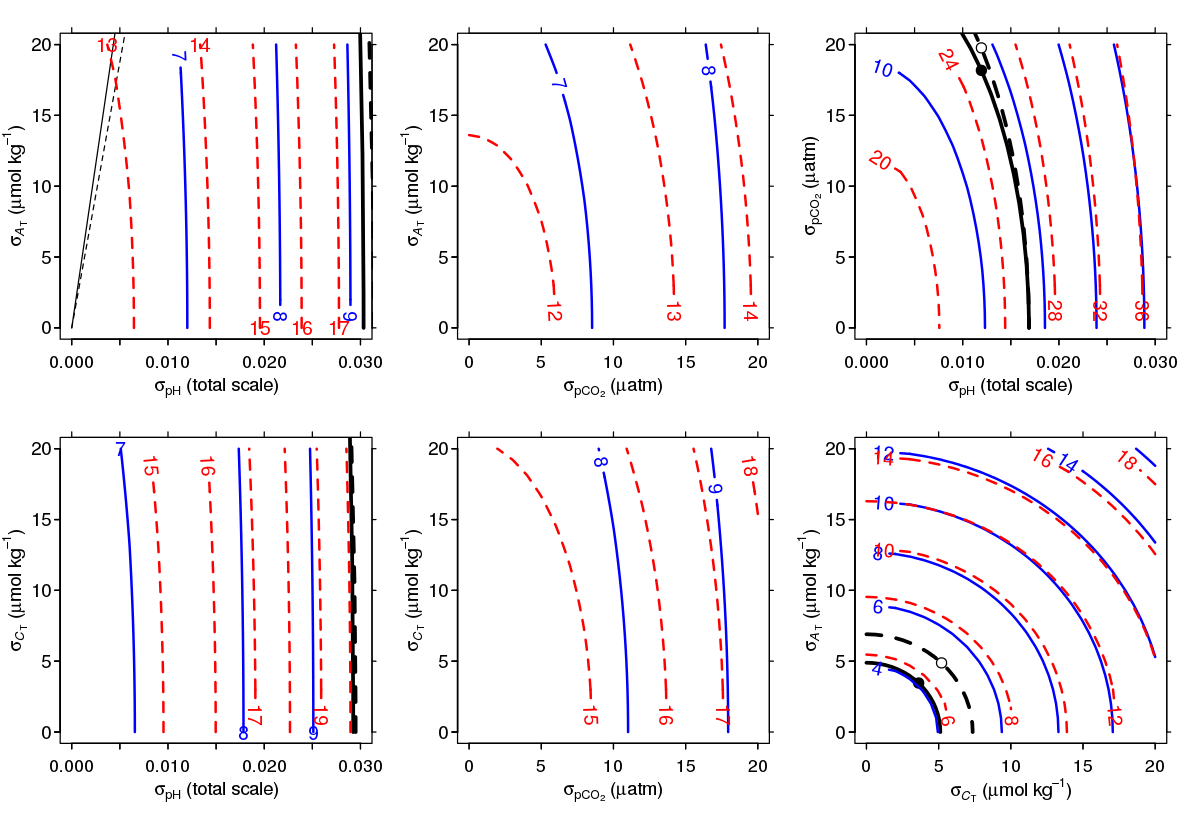

In [57]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="StackedErrors_socn_varsK.pdf",  width=8.5, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(pHsocn) <- c(length(DIC_e), length(ALK_e))
    dim(pHtrop) <- c(length(DIC_e), length(ALK_e))

    dim(pCO2socn) <- c(length(DIC_e), length(ALK_e))
    dim(pCO2trop) <- c(length(DIC_e), length(ALK_e))

    dim(CO3socn) <- c(length(DIC_e), length(ALK_e))
    dim(CO3trop) <- c(length(DIC_e), length(ALK_e))

    dim(CO3_pHAt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pHAt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(CO3_pHCt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pHCt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(CO3_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(CO3_pCO2At_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pCO2At_trop) <- c(length(pCO2_e), length(pH_e))

    dim(CO3_pCO2Ct_socn) <- c(length(pCO2_e), length(pH_e))
    dim(CO3_pCO2Ct_trop) <- c(length(pCO2_e), length(pH_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
    par(mfrow=c(2,3), mar=c(4,3.7,2,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL


#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHAt_socn$CO3  ;  sigcritYa <- sig2_pHAt_socn$CO3
    sigcritXb <- sig1_pHAt_trop$CO3  ;  sigcritYb <- sig2_pHAt_trop$CO3
    x <- pH_e  ;  y <- ALK_e*1e+6
    za <- CO3_pHAt_socn*1e+6   ;  zb <- CO3_pHAt_trop*1e+6 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- seq(1,20,by=1)   ;  levels2 <- levels1

#   plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
#                  sigcritXb, sigcritYb, 
#                  x, y, za, levels1,
#                        zb, levels2,
#                  'edge', 'simple')
    plterrcontourQ (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$CO3), zenon(sigm2_pHAt_socn$CO3),
                   zenon(sigm1_pHAt_trop$CO3), zenon(sigm2_pHAt_trop$CO3),
                   x, y, za, levels1,
                   zb, levels2,
                   'edge', 'simple')
#   plterrcontourQ (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
#                  sigcritXb, sigcritYb, 
#                  x, y, za, levels1,
#                        zb, levels2,
#                  'edge', 'simple')

    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')
#mid1_pHAt_socn
#mid2_pHAt_socn

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$CO3  ;  sigcritYa <- sig2_pCO2At_socn$CO3 
    sigcritXb <- sig1_pCO2At_trop$CO3  ;  sigcritYb <- sig2_pCO2At_trop$CO3
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- CO3_pCO2At_socn*1e+6   ;  zb <- CO3_pCO2At_trop*1e+6 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1,seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)
 
    cat('pCO2-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   3. pH-pCO2
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$CO3  ;  sigcritYa <- sig1_pCO2pH_socn$CO3
    sigcritXb <- sig2_pCO2pH_trop$CO3  ;  sigcritYb <- sig1_pCO2pH_trop$CO3
    x <- pH_e  ;  y <- pCO2_e
    za <- t(CO3_pCO2pH_socn*1e+6)  ;  zb <- t(CO3_pCO2pH_trop*1e+6)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- seq(0,20,by=2)  ;  levels2 <- seq(0,40,by=4)

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)
    cat('pH-pCO2: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$CO3  ;  sigcritYa <- sig2_pHCt_socn$CO3
    sigcritXb <- sig1_pHCt_trop$CO3  ;  sigcritYb <- sig2_pHCt_trop$CO3
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- CO3_pHCt_socn*1e+6   ;  zb <- CO3_pHCt_trop*1e+6 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- seq(1,20,by=1)   ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2,
                   'simple', 'edge')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$CO3 ;  sigcritYa <- sig2_pCO2Ct_socn$CO3
    sigcritXb <- sig1_pCO2Ct_trop$CO3 ;  sigcritYb <- sig2_pCO2Ct_trop$CO3
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- CO3_pCO2Ct_socn*1e+6   ;  zb <- CO3_pCO2Ct_trop*1e+6 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(1,20,by=1)   ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)
    cat('pCO2-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO3  ;  sigcritYa <- sig1_AtCt_socn$CO3  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO3  ;  sigcritYb <- sig1_AtCt_trop$CO3
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- CO3socn*1e6  ;  zb <- CO3trop*1e6
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb, 
                   x, y, za, levels1,
                         zb, levels2)
    cat('At-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

#### 4.3.4 Plot Relative error in CO3  for 6 input pairs (1 subplot each)

In [60]:
### Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_CO3.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rCO3socn) <- c(length(DIC_e), length(ALK_e))
    dim(rCO3trop) <- c(length(DIC_e), length(ALK_e))

    dim(rCO3_pHAt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pHAt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO3_pHCt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pHCt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO3_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO3_pCO2At_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pCO2At_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO3_pCO2Ct_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pCO2Ct_trop) <- c(length(pCO2_e), length(pH_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$CO3 ;  sigcritYa <- sig2_pHAt_socn$CO3
    sigcritXb <- sig1_pHAt_trop$CO3 ;  sigcritYb <- sig2_pHAt_trop$CO3
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rCO3_pHAt_socn   ;  zb <- rCO3_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(4.2, seq(4,7,by=1))   ;  levels2 <- c(3.75, seq(4,7,by=1))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$CO3), zenon(sigm2_pHAt_socn$CO3),
                   zenon(sigm1_pHAt_trop$CO3), zenon(sigm2_pHAt_trop$CO3),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$CO3  ;  sigcritYa <- sig2_pCO2At_socn$CO3
    sigcritXb <- sig1_pCO2At_trop$CO3  ;  sigcritYb <- sig2_pCO2At_trop$CO3
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rCO3_pCO2At_socn   ;  zb <- rCO3_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(3,7,by=0.5)  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$CO3), zenon(sigm2_pCO2At_socn$CO3),
                   zenon(sigm1_pCO2At_trop$CO3), zenon(sigm2_pCO2At_trop$CO3),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')


#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$CO3  ;  sigcritYa <- sig1_pCO2pH_socn$CO3
    sigcritXb <- sig2_pCO2pH_trop$CO3  ;  sigcritYb <- sig1_pCO2pH_trop$CO3
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rCO3_pCO2pH_socn)  ;  zb <- t(rCO3_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- c(5.4, 7, seq(0,20,by=2))  ;  levels2 <- c(5.4, 7, seq(0,20,by=2))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_pCO2pH_socn$CO3), zenon(sigm1_pCO2pH_socn$CO3),
                   zenon(sigm2_pCO2pH_trop$CO3), zenon(sigm1_pCO2pH_trop$CO3),
                   pH_e_soa2, pCO2_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$CO3  ;  sigcritYa <- sig2_pHCt_socn$CO3
    sigcritXb <- sig1_pHCt_trop$CO3  ;  sigcritYb <- sig2_pHCt_trop$CO3
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rCO3_pHCt_socn   ;  zb <- rCO3_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(4.5, seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$CO3), zenon(sigm2_pHCt_socn$CO3),
                   zenon(sigm1_pHCt_trop$CO3), zenon(sigm2_pHCt_trop$CO3),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$CO3 ;  sigcritYa <- sig2_pCO2Ct_socn$CO3
    sigcritXb <- sig1_pCO2Ct_trop$CO3 ;  sigcritYb <- sig2_pCO2Ct_trop$CO3 
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rCO3_pCO2Ct_socn  ;  zb <- rCO3_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(4.7,seq(1,20,by=1))   ;  levels2 <- c(4.1, 4.5,seq(1,20,by=1))


    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$CO3), zenon(sigm2_pCO2Ct_socn$CO3),
                   zenon(sigm1_pCO2Ct_trop$CO3), zenon(sigm2_pCO2Ct_trop$CO3),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')


#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO3  ;  sigcritYa <- sig1_AtCt_socn$CO3  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO3  ;  sigcritYb <- sig1_AtCt_trop$CO3
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rCO3socn  ;  zb <- rCO3trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$CO3), zenon(sigm1_AtCt_socn$CO3),
                   zenon(sigm2_AtCt_trop$CO3), zenon(sigm1_AtCt_trop$CO3),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

# Turn off device driver (to flush output to PDF)
# dev.off()

***Figure:*** Percent relative uncertainty in computed $[\text{CO}_3^{2-}]$ from six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### 4.3.5 Plot Relative error in $\Omega_A$  for 6 input pairs

pH-At: xcrit, ycrit =  0.02660174 123129784 
pCO2-At: xcrit, ycrit =  23.20045 69.71773 
pCO2-pH: xcrit, ycrit =  0.01387894 21.12717 
pH-Ct: xcrit, ycrit =  0.0252445 122.3637 
pCO2-Ct: xcrit, ycrit =  21.25584 66.70345 
At-Ct: xcrit, ycrit =  7.002845 6.698274 


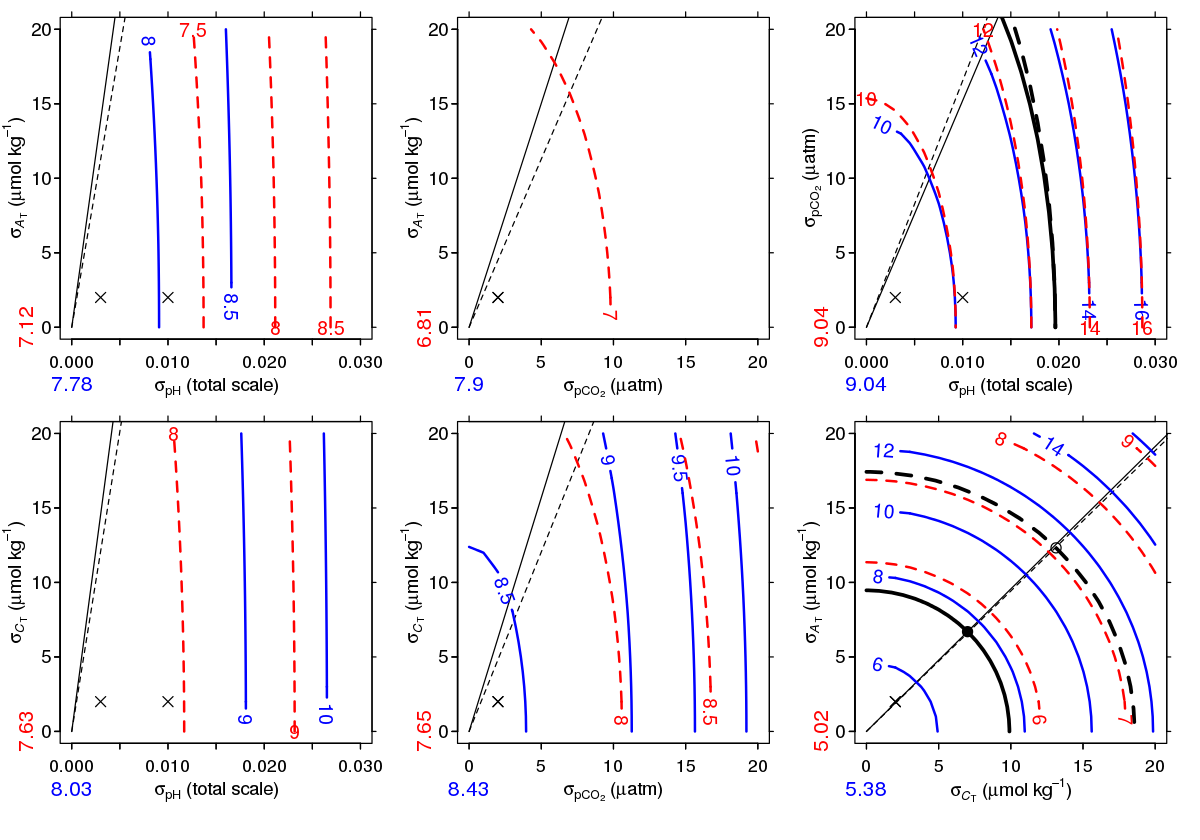

In [61]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_OmegaA.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rOmegaAsocn) <- c(length(DIC_e), length(ALK_e))
    dim(rOmegaAtrop) <- c(length(DIC_e), length(ALK_e))

    dim(rOmegaA_pHAt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pHAt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pHCt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pHCt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2At_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2At_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2Ct_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2Ct_trop) <- c(length(pCO2_e), length(pH_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$OmegaAragonite ;  sigcritYa <- sig2_pHAt_socn$OmegaAragonite*1e+6 
    sigcritXb <- sig1_pHAt_trop$OmegaAragonite ;  sigcritYb <- sig2_pHAt_trop$OmegaAragonite*1e+6
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rOmegaA_pHAt_socn   ;  zb <- rOmegaA_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(6.25, seq(4,8.5,by=0.5))   ;  levels2 <- c(5.9, seq(4,8.5,by=0.5))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$OmegaAragonite), zenon(sigm2_pHAt_socn$OmegaAragonite),
                   zenon(sigm1_pHAt_trop$OmegaAragonite), zenon(sigm2_pHAt_trop$OmegaAragonite),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')

    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$OmegaAragonite  ;  sigcritYa <- sig2_pCO2At_socn$OmegaAragonite
    sigcritXb <- sig1_pCO2At_trop$OmegaAragonite  ;  sigcritYb <- sig2_pCO2At_trop$OmegaAragonite 
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rOmegaA_pCO2At_socn   ;  zb <- rOmegaA_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(5.7, 6.2, seq(0,7,by=0.5))  ;  levels2 <- c(5.7, seq(0,7,by=0.5))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$OmegaAragonite), zenon(sigm2_pCO2At_socn$OmegaAragonite),
                   zenon(sigm1_pCO2At_trop$OmegaAragonite), zenon(sigm2_pCO2At_trop$OmegaAragonite),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')
 

#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$OmegaAragonite  ;  sigcritYa <- sig1_pCO2pH_socn$OmegaAragonite
    sigcritXb <- sig2_pCO2pH_trop$OmegaAragonite  ;  sigcritYb <- sig1_pCO2pH_trop$OmegaAragonite
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rOmegaA_pCO2pH_socn)  ;  zb <- t(rOmegaA_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- c(7,seq(0,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_pCO2pH_socn$OmegaAragonite), zenon(sigm1_pCO2pH_socn$OmegaAragonite),
                   zenon(sigm2_pCO2pH_trop$OmegaAragonite), zenon(sigm1_pCO2pH_trop$OmegaAragonite),
                   pH_e_soa2, pCO2_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pCO2-pH: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$OmegaAragonite  ;  sigcritYa <- sig2_pHCt_socn$OmegaAragonite
    sigcritXb <- sig1_pHCt_trop$OmegaAragonite  ;  sigcritYb <- sig2_pHCt_trop$OmegaAragonite
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rOmegaA_pHCt_socn   ;  zb <- rOmegaA_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(6.4, 6.5,seq(3,10,by=1))   ;  levels2 <- c(6.2, 6.5,seq(3,10,by=1)) 

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$OmegaAragonite), zenon(sigm2_pHCt_socn$OmegaAragonite),
                   zenon(sigm1_pHCt_trop$OmegaAragonite), zenon(sigm2_pHCt_trop$OmegaAragonite),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$OmegaAragonite ;  sigcritYa <- sig2_pCO2Ct_socn$OmegaAragonite
    sigcritXb <- sig1_pCO2Ct_trop$OmegaAragonite ;  sigcritYb <- sig2_pCO2Ct_trop$OmegaAragonite 
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rOmegaA_pCO2Ct_socn  ;  zb <- rOmegaA_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(6.6, seq(3,10,by=0.5))   ;  levels2 <- c(6.2, seq(3,10,by=0.5)) 

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$OmegaAragonite), zenon(sigm2_pCO2Ct_socn$OmegaAragonite),
                   zenon(sigm1_pCO2Ct_trop$OmegaAragonite), zenon(sigm2_pCO2Ct_trop$OmegaAragonite),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$OmegaAragonite  ;  sigcritYa <- sig1_AtCt_socn$OmegaAragonite  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$OmegaAragonite  ;  sigcritYb <- sig1_AtCt_trop$OmegaAragonite
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rOmegaAsocn  ;  zb <- rOmegaAtrop
    xlim <- c(0,20)  ; ylim <- xlim
#   levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- c(1,seq(2,20,by=1))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$OmegaAragonite), zenon(sigm1_AtCt_socn$OmegaAragonite),
                   zenon(sigm2_AtCt_trop$OmegaAragonite), zenon(sigm1_AtCt_trop$OmegaAragonite),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

    cat('At-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

***Figure:*** Percent relative uncertainty in computed $\Omega_A$ from six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### TTEST plterrcontourS

In [62]:
plterrcontourS <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sighpXa, sighpYa,
                           sighpXb, sighpYb,
                           sigmidXa, sigmidYa,
                           sigmidXb, sigmidYb,
                           sigsoaX, sigsoaY,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    if ( is.null(sighpXa) ) {
        points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
        points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
    } else {
        points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
        points(sighpXb, sighpYb, col="black", cex=1.7, pch=1)
    }    
#   Plot mid-line (where e1 = e2 on each isoline [and between isolines])
    lines(sigmidXa, sigmidYa, col="black", lwd=1, lty='solid')
    lines(sigmidXb, sigmidYb, col="black", lwd=1, lty='dashed')
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
#   Plot point(s) at state-of-the-art (soa) for absolute error in each member of the input pair
#   - pH has 2 points (random & overall error); other 3 input variables only have 1 point
    points(sigsoaX, sigsoaY, col="black", cex=1.7, pch=4)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)

if (is.null(george)) {aaa <-3}
    
#   Add 2 colored text strings near origin to indicate the propagated error at the origin (from constants only)
    if ( !is.null(za) ) {
    a0 <- za[1,1]
    if (a0 < 1) {ndiga <- 2} else {ndiga <- 3}
    mtext( format(a0, digits=ndiga), side=1, line=2.5, at=0, srt=0,  cex=1.05, col='blue')
    }
    
    if ( !is.null(zb) ) {
    b0 <- zb[1,1]
    if (b0 < 1) {ndigb <- 2} else {ndigb <- 3}
    mtext( format(b0, digits=ndigb), side=2, line=1.5, at=0, srt=90, cex=1.05, col='red')
    }

#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    if ( !is.null(zb) ) {
    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)
    }
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

At-Ct: xcrit, ycrit =  7.002845 6.698274 


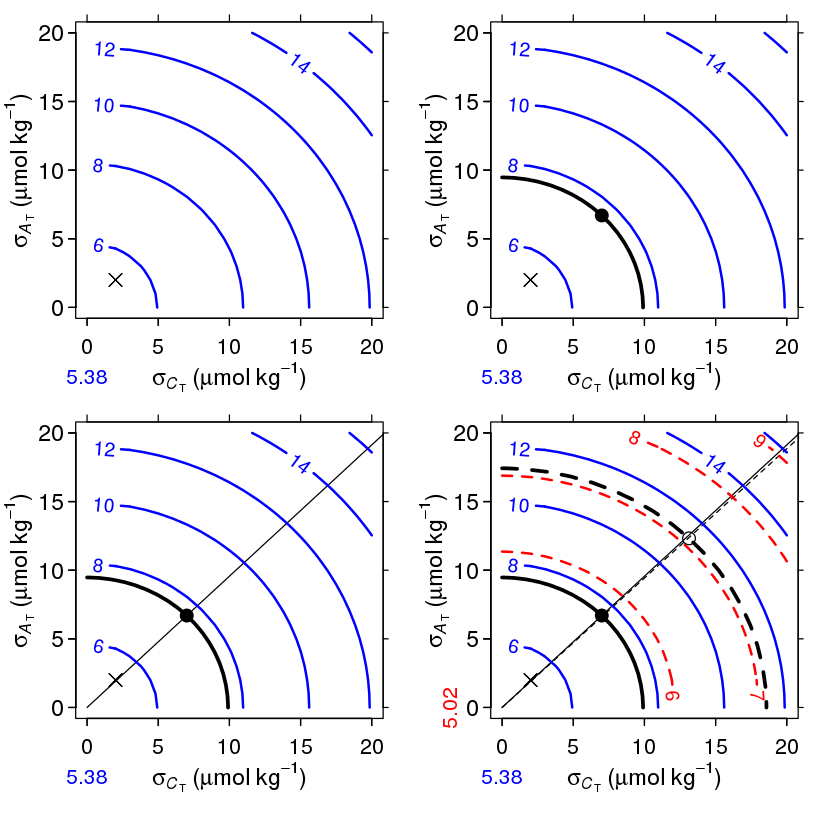

In [81]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
#  pdf(file="Anatomy_halfway_OmegaA.pdf",  width=7.0, height=7.0)

  options(repr.plot.width=7.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rOmegaAsocn) <- c(length(DIC_e), length(ALK_e))
    dim(rOmegaAtrop) <- c(length(DIC_e), length(ALK_e))

    dim(rOmegaA_pHAt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pHAt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pHCt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pHCt_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2At_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2At_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rOmegaA_pCO2Ct_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rOmegaA_pCO2Ct_trop) <- c(length(pCO2_e), length(pH_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,2), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 

#   1. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$OmegaAragonite  ;  sigcritYa <- sig1_AtCt_socn$OmegaAragonite  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$OmegaAragonite  ;  sigcritYb <- sig1_AtCt_trop$OmegaAragonite
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rOmegaAsocn  ;  zb <- rOmegaAtrop
    xlim <- c(0,20)  ; ylim <- xlim
#   levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- c(1,seq(2,20,by=1))

    plterrcontourS (NULL, NULL, xlabel, ylabel, subtitle, xlim, ylim,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         NULL, levels2,
                   'flattest', 'edge')

##   2. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$OmegaAragonite  ;  sigcritYa <- sig1_AtCt_socn$OmegaAragonite  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$OmegaAragonite  ;  sigcritYb <- sig1_AtCt_trop$OmegaAragonite
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rOmegaAsocn  ;  zb <- rOmegaAtrop
    xlim <- c(0,20)  ; ylim <- xlim
#   levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- c(1,seq(2,20,by=1))

    plterrcontourS (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         NULL, levels2,
                   'flattest', 'edge')

#   3. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$OmegaAragonite  ;  sigcritYa <- sig1_AtCt_socn$OmegaAragonite  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$OmegaAragonite  ;  sigcritYb <- sig1_AtCt_trop$OmegaAragonite
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rOmegaAsocn  ;  zb <- rOmegaAtrop
    xlim <- c(0,20)  ; ylim <- xlim
#   levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- c(1,seq(2,20,by=1))

    plterrcontourS (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   NULL, NULL,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$OmegaAragonite), zenon(sigm1_AtCt_socn$OmegaAragonite),
                   NULL, NULL,
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         NULL, levels2,
                   'flattest', 'edge')

#   4. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$OmegaAragonite  ;  sigcritYa <- sig1_AtCt_socn$OmegaAragonite  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$OmegaAragonite  ;  sigcritYb <- sig1_AtCt_trop$OmegaAragonite
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rOmegaAsocn  ;  zb <- rOmegaAtrop
    xlim <- c(0,20)  ; ylim <- xlim
#   levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- c(1,seq(2,20,by=1))

    plterrcontourS (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$OmegaAragonite), zenon(sigm1_AtCt_socn$OmegaAragonite),
                   zenon(sigm2_AtCt_trop$OmegaAragonite), zenon(sigm1_AtCt_trop$OmegaAragonite),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

    cat('At-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

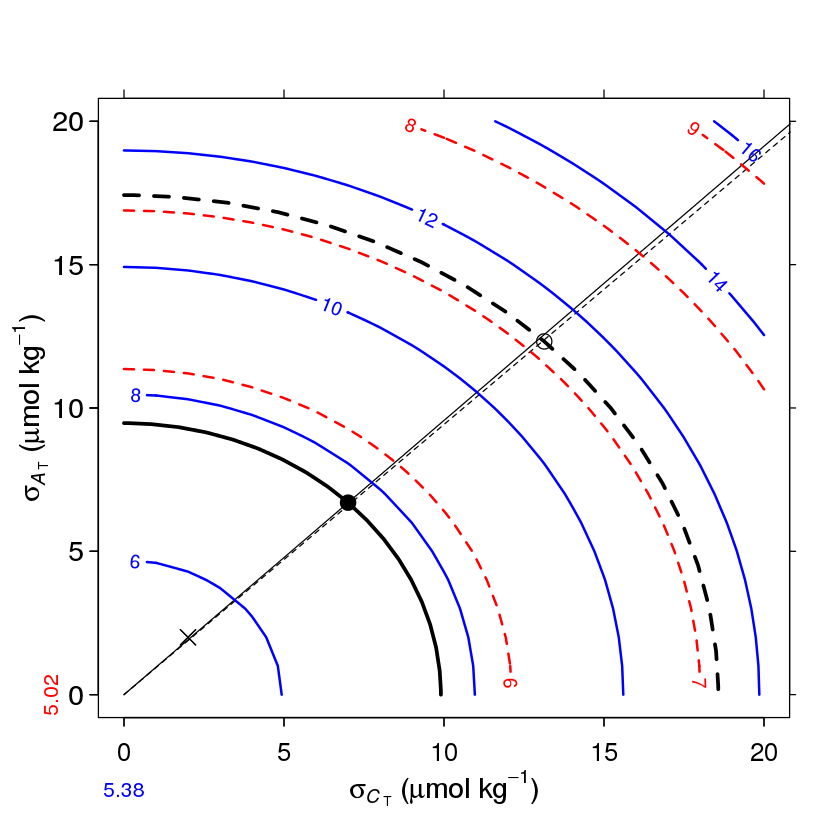

In [82]:
    plterrcontourS (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$OmegaAragonite), zenon(sigm1_AtCt_socn$OmegaAragonite),
                   zenon(sigm2_AtCt_trop$OmegaAragonite), zenon(sigm1_AtCt_trop$OmegaAragonite),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')


#### 4.3.6 Plot Relative error in CO2*  for 6 input pairs

pH-At: xcrit, ycrit =  0.009687901 55.56969 
pCO2-At: xcrit, ycrit =  2.152772 Inf 
pCO2-pH: xcrit, ycrit =  Inf 2.152772 
pH-Ct: xcrit, ycrit =  0.01016642 52.36026 
pCO2-Ct: xcrit, ycrit =  2.152772 Inf 
At-Ct: xcrit, ycrit =    5.096323 5.677044 


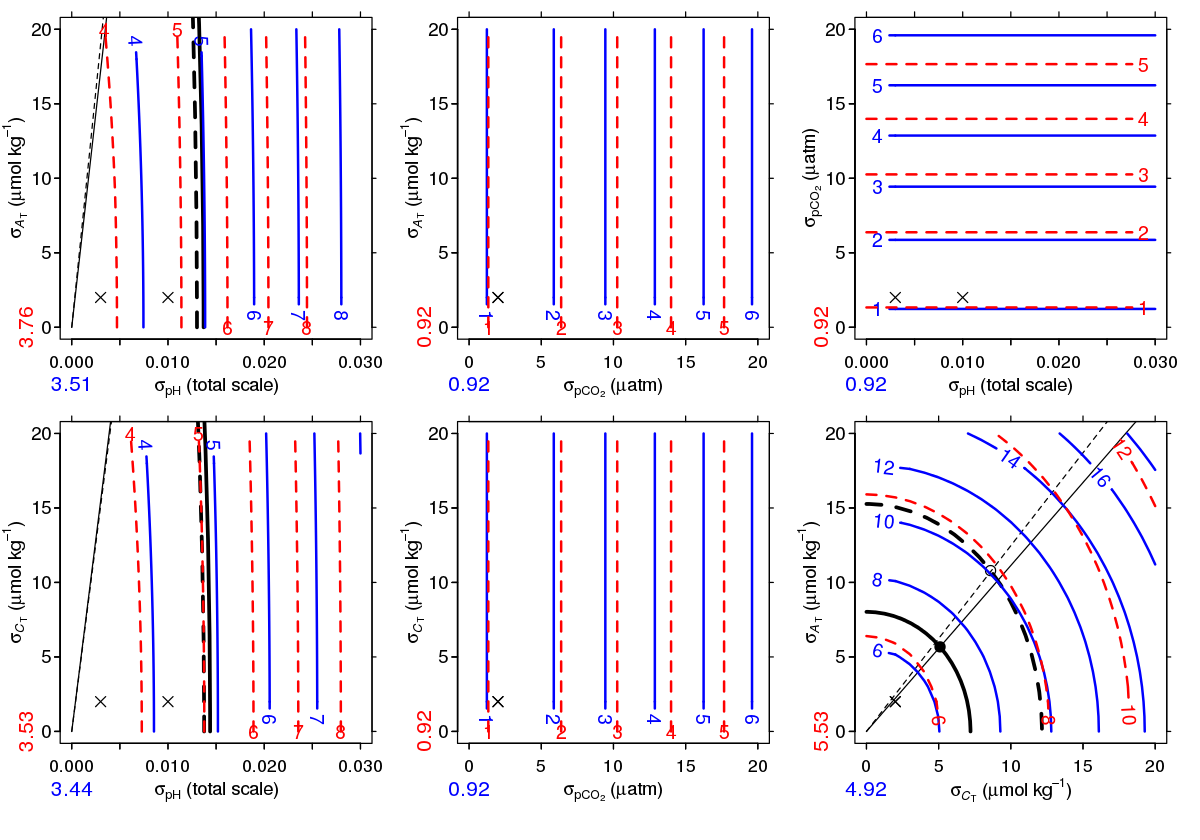

In [83]:
### Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_CO2.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rCO2socn) <- c(length(DIC_e), length(ALK_e))
    dim(rCO2trop) <- c(length(DIC_e), length(ALK_e))

    dim(rCO2_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rCO2_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rCO2_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rCO2_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rCO2_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO2_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO2_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rCO2_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rCO2_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rCO2_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$CO2 ;  sigcritYa <- sig2_pHAt_socn$CO2
    sigcritXb <- sig1_pHAt_trop$CO2 ;  sigcritYb <- sig2_pHAt_trop$CO2
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rCO2_pHAt_socn   ;  zb <- rCO2_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(0,8,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$CO2), zenon(sigm2_pHAt_socn$CO2),
                   zenon(sigm1_pHAt_trop$CO2), zenon(sigm2_pHAt_trop$CO2),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$CO2  ;  sigcritYa <- sig2_pCO2At_socn$CO2
    sigcritXb <- sig1_pCO2At_trop$CO2  ;  sigcritYb <- sig2_pCO2At_trop$CO2
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rCO2_pCO2At_socn   ;  zb <- rCO2_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.5, seq(0,8,by=1))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$CO2), zenon(sigm2_pCO2At_socn$CO2),
                   zenon(sigm1_pCO2At_trop$CO2), zenon(sigm2_pCO2At_trop$CO2),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
     cat('pCO2-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$CO2  ;  sigcritYa <- sig1_pCO2pH_socn$CO2
    sigcritXb <- sig2_pCO2pH_trop$CO2  ;  sigcritYb <- sig1_pCO2pH_trop$CO2
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rCO2_pCO2pH_socn)  ;  zb <- t(rCO2_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- c(0.5, seq(0,20,by=1))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_pCO2pH_socn$CO2), zenon(sigm1_pCO2pH_socn$CO2),
                   zenon(sigm2_pCO2pH_trop$CO2), zenon(sigm1_pCO2pH_trop$CO2),
                   pH_e_soa2, pCO2_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-pH: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$CO2  ;  sigcritYa <- sig2_pHCt_socn$CO2
    sigcritXb <- sig1_pHCt_trop$CO2  ;  sigcritYb <- sig2_pHCt_trop$CO2
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rCO2_pHCt_socn   ;  zb <- rCO2_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$CO2), zenon(sigm2_pHCt_socn$CO2),
                   zenon(sigm1_pHCt_trop$CO2), zenon(sigm2_pHCt_trop$CO2),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$CO2 ;  sigcritYa <- sig2_pCO2Ct_socn$CO2
    sigcritXb <- sig1_pCO2Ct_trop$CO2 ;  sigcritYb <- sig2_pCO2Ct_trop$CO2 
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rCO2_pCO2Ct_socn  ;  zb <- rCO2_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.5, seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$CO2), zenon(sigm2_pCO2Ct_socn$CO2),
                   zenon(sigm1_pCO2Ct_trop$CO2), zenon(sigm2_pCO2Ct_trop$CO2),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pCO2-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO2  ;  sigcritYa <- sig1_AtCt_socn$CO2  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO2  ;  sigcritYb <- sig1_AtCt_trop$CO2
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rCO2socn  ;  zb <- rCO2trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1, 3, seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$CO2), zenon(sigm1_AtCt_socn$CO2),
                   zenon(sigm2_AtCt_trop$CO2), zenon(sigm1_AtCt_trop$CO2),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('At-Ct: xcrit, ycrit =   ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
#  dev.off()

#### same CO2* as just above, BUT show only the 3 pairs without pCO2 as member

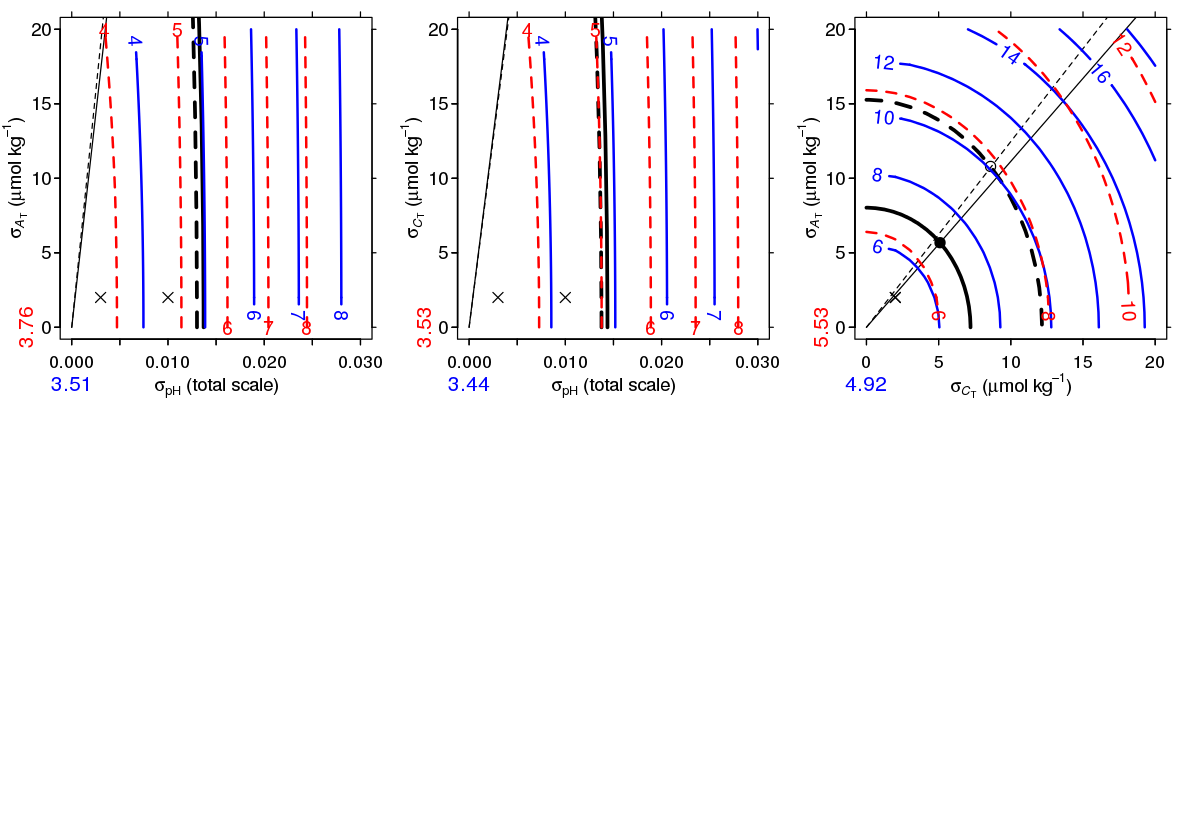

In [84]:
### Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_CO2_trois.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rCO2socn) <- c(length(DIC_e), length(ALK_e))
    dim(rCO2trop) <- c(length(DIC_e), length(ALK_e))

    dim(rCO2_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rCO2_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rCO2_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rCO2_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rCO2_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO2_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rCO2_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rCO2_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rCO2_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rCO2_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$CO2 ;  sigcritYa <- sig2_pHAt_socn$CO2
    sigcritXb <- sig1_pHAt_trop$CO2 ;  sigcritYb <- sig2_pHAt_trop$CO2
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rCO2_pHAt_socn   ;  zb <- rCO2_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(0,8,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$CO2), zenon(sigm2_pHAt_socn$CO2),
                   zenon(sigm1_pHAt_trop$CO2), zenon(sigm2_pHAt_trop$CO2),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$CO2  ;  sigcritYa <- sig2_pHCt_socn$CO2
    sigcritXb <- sig1_pHCt_trop$CO2  ;  sigcritYb <- sig2_pHCt_trop$CO2
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rCO2_pHCt_socn   ;  zb <- rCO2_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$CO2), zenon(sigm2_pHCt_socn$CO2),
                   zenon(sigm1_pHCt_trop$CO2), zenon(sigm2_pHCt_trop$CO2),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO2  ;  sigcritYa <- sig1_AtCt_socn$CO2  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO2  ;  sigcritYb <- sig1_AtCt_trop$CO2
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rCO2socn  ;  zb <- rCO2trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1, 3, seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$CO2), zenon(sigm1_AtCt_socn$CO2),
                   zenon(sigm2_AtCt_trop$CO2), zenon(sigm1_AtCt_trop$CO2),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

# Turn off device driver (to flush output to PDF)
# dev.off()

***Figure:*** Percent relative uncertainty in the computed $[\text{CO}_2^*]$  for six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### 4.3.7 Plot Relative error in HCO3-  for 6 input pairs

In [85]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_HCO3.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

    dim(rHCO3socn) <- c(length(DIC_e), length(ALK_e))
    dim(rHCO3trop) <- c(length(DIC_e), length(ALK_e))

    dim(rHCO3_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rHCO3_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rHCO3_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rHCO3_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rHCO3_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rHCO3_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rHCO3_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rHCO3_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rHCO3_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rHCO3_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$HCO3 ;  sigcritYa <- sig2_pHAt_socn$HCO3 
    sigcritXb <- sig1_pHAt_trop$HCO3 ;  sigcritYb <- sig2_pHAt_trop$HCO3
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rHCO3_pHAt_socn   ;  zb <- rHCO3_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(0.5, seq(0,3,by=0.2))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$HCO3), zenon(sigm2_pHAt_socn$HCO3),
                   zenon(sigm1_pHAt_trop$HCO3), zenon(sigm2_pHAt_trop$HCO3),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest','edge')
    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$HCO3  ;  sigcritYa <- sig2_pCO2At_socn$HCO3 
    sigcritXb <- sig1_pCO2At_trop$HCO3  ;  sigcritYb <- sig2_pCO2At_trop$HCO3
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rHCO3_pCO2At_socn   ;  zb <- rHCO3_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.5, seq(0,3,by=0.2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$HCO3), zenon(sigm2_pCO2At_socn$HCO3),
                   zenon(sigm1_pCO2At_trop$HCO3), zenon(sigm2_pCO2At_trop$HCO3),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'flattest')
    cat('pCO2-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')
 

#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$HCO3  ;  sigcritYa <- sig1_pCO2pH_socn$HCO3
    sigcritXb <- sig2_pCO2pH_trop$HCO3  ;  sigcritYb <- sig1_pCO2pH_trop$HCO3
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rHCO3_pCO2pH_socn)  ;  zb <- t(rHCO3_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- seq(0,20,by=1)  ;  levels2 <- seq(0,20,by=1)

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_pCO2pH_socn$HCO3), zenon(sigm1_pCO2pH_socn$HCO3),
                   zenon(sigm2_pCO2pH_trop$HCO3), zenon(sigm1_pCO2pH_trop$HCO3),
                   pH_e_soa2, pCO2_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-pH: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$HCO3  ;  sigcritYa <- sig2_pHCt_socn$HCO3
    sigcritXb <- sig1_pHCt_trop$HCO3  ;  sigcritYb <- sig2_pHCt_trop$HCO3
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rHCO3_pHCt_socn   ;  zb <- rHCO3_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(0.25, seq(0,2,by=0.2))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$HCO3), zenon(sigm2_pHCt_socn$HCO3),
                   zenon(sigm1_pHCt_trop$HCO3), zenon(sigm2_pHCt_trop$HCO3),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$HCO3 ;  sigcritYa <- sig2_pCO2Ct_socn$HCO3
    sigcritXb <- sig1_pCO2Ct_trop$HCO3 ;  sigcritYb <- sig2_pCO2Ct_trop$HCO3
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rHCO3_pCO2Ct_socn  ;  zb <- rHCO3_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.3, seq(0.4,3,by=0.2))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$HCO3), zenon(sigm2_pCO2Ct_socn$HCO3),
                   zenon(sigm1_pCO2Ct_trop$HCO3), zenon(sigm2_pCO2Ct_trop$HCO3),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$HCO3  ;  sigcritYa <- sig1_AtCt_socn$HCO3  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$HCO3  ;  sigcritYb <- sig1_AtCt_trop$HCO3
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rHCO3socn  ;  zb <- rHCO3trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.2, 0.5, by=0.3)  ;  levels2 <- levels1
    levels1 <- c(0.2, seq(0.4, 2.0, by=0.4))  ;  levels2 <- levels1
    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$HCO3), zenon(sigm1_AtCt_socn$HCO3),
                   zenon(sigm2_AtCt_trop$HCO3), zenon(sigm1_AtCt_trop$HCO3),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('At-Ct: xcrit, ycrit =   ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

pH-At: xcrit, ycrit =  0.01700486 10.07381 
pCO2-At: xcrit, ycrit =  15.54634 11.83003 
pCO2-pH: xcrit, ycrit =  0.01097725 8.355037 
pH-Ct: xcrit, ycrit =  0.02626559 5.04685 
pCO2-Ct: xcrit, ycrit =  22.91948 5.573062 
At-Ct: xcrit, ycrit =    1.87085 5.78824 


***Figure:*** Percent relative uncertainty in computed $[\text{HCO}_3^{-}]$ from six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### 4.3.8 Plot Relative error in H+  for 6 input pairs

In [86]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_H.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

    dim(rHsocn) <- c(length(DIC_e), length(ALK_e))
    dim(rHtrop) <- c(length(DIC_e), length(ALK_e))

    dim(rH_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rH_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rH_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rH_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rH_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rH_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rH_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rH_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rH_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rH_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- NULL ;  sigcritYa <- NULL
    sigcritXb <- NULL ;  sigcritYb <- NULL
   x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rH_pHAt_socn   ;  zb <- rH_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- seq(0,20,by=1)   ;  levels2 <- levels1

#   plterrcontour (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
#                 sigcritXb, sigcritYb, 
#                  x, y, za, levels1,
#                        zb, levels2,
#                  'flattest','edge')
    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$H), zenon(sigm2_pHAt_socn$H),
                   zenon(sigm1_pHAt_trop$H), zenon(sigm2_pHAt_trop$H),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest','edge')
    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$H  ;  sigcritYa <- sig2_pCO2At_socn$H
    sigcritXb <- sig1_pCO2At_trop$H  ;  sigcritYb <- sig2_pCO2At_trop$H
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rH_pCO2At_socn   ;  zb <- rH_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(2.2, 2.5,seq(3,10,by=1), 4.5)  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$H), zenon(sigm2_pCO2At_socn$H),
                   zenon(sigm1_pCO2At_trop$H), zenon(sigm2_pCO2At_trop$H),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'flattest')
    cat('pCO2-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')
 
#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$H  ;  sigcritYa <- sig1_pCO2pH_socn$H
    sigcritXb <- sig2_pCO2pH_trop$H  ;  sigcritYb <- sig1_pCO2pH_trop$H
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rH_pCO2pH_socn)  ;  zb <- t(rH_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- seq(0,20,by=1)  ;  levels2 <- seq(0,20,by=1)

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_pCO2pH_socn$H), zenon(sigm1_pCO2pH_socn$H),
                   zenon(sigm2_pCO2pH_trop$H), zenon(sigm1_pCO2pH_trop$H),
                   pH_e_soa2, pCO2_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-pH: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')


#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- NULL ;  sigcritYa <- NULL
    sigcritXb <- NULL ;  sigcritYb <- NULL
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rH_pHCt_socn   ;  zb <- rH_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(0, seq(0,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$H), zenon(sigm2_pHCt_socn$H),
                   zenon(sigm1_pHCt_trop$H), zenon(sigm2_pHCt_trop$H),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge','flattest')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$H ;  sigcritYa <- sig2_pCO2Ct_socn$H
    sigcritXb <- sig1_pCO2Ct_trop$H ;  sigcritYb <- sig2_pCO2Ct_trop$H
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rH_pCO2Ct_socn  ;  zb <- rH_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.3, seq(0.4,3,by=0.2))   ;  levels2 <- levels1
    levels1 <- c(2.2, 2.5,seq(3,7,by=1))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$H), zenon(sigm2_pCO2Ct_socn$H),
                   zenon(sigm1_pCO2Ct_trop$H), zenon(sigm2_pCO2Ct_trop$H),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$H  ;  sigcritYa <- sig1_AtCt_socn$H  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$H  ;  sigcritYb <- sig1_AtCt_trop$H
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rHsocn  ;  zb <- rHtrop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(3, 14, by=2)  ;  levels2 <- seq(3, 14, by=1)
    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$H), zenon(sigm1_AtCt_socn$H),
                   zenon(sigm2_AtCt_trop$H), zenon(sigm1_AtCt_trop$H),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'flattest')
    cat('At-Ct: xcrit, ycrit =   ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'

pH-At: xcrit, ycrit =  
pCO2-At: xcrit, ycrit =  8.483959 57.44475 


Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'

pCO2-pH: xcrit, ycrit =  


Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'Warning message:
In is.na(x): is.na() applied to non-(list or vector) of type 'NULL'

pH-Ct: xcrit, ycrit =  
pCO2-Ct: xcrit, ycrit =  8.313166 54.1969 
At-Ct: xcrit, ycrit =    4.756666 4.938554 


***Figure:*** Percent relative uncertainty in computed $[\text{H}^{+}]$ from six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### same Plot for Relative error in H+  as just above but only for 3 input pairs (omit those having pH as a member)

In [87]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_H_trois.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

    dim(rHsocn) <- c(length(DIC_e), length(ALK_e))
    dim(rHtrop) <- c(length(DIC_e), length(ALK_e))

    dim(rH_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rH_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rH_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rH_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rH_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rH_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rH_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rH_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rH_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rH_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$H  ;  sigcritYa <- sig2_pCO2At_socn$H
    sigcritXb <- sig1_pCO2At_trop$H  ;  sigcritYb <- sig2_pCO2At_trop$H
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rH_pCO2At_socn   ;  zb <- rH_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(2.2, 2.5,seq(3,10,by=1), 4.5)  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2At_socn$H), zenon(sigm2_pCO2At_socn$H),
                   zenon(sigm1_pCO2At_trop$H), zenon(sigm2_pCO2At_trop$H),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'flattest')
 
#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$H ;  sigcritYa <- sig2_pCO2Ct_socn$H
    sigcritXb <- sig1_pCO2Ct_trop$H ;  sigcritYb <- sig2_pCO2Ct_trop$H
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rH_pCO2Ct_socn  ;  zb <- rH_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.3, seq(0.4,3,by=0.2))   ;  levels2 <- levels1
    levels1 <- c(2.2, 2.5,seq(3,7,by=1))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pCO2Ct_socn$H), zenon(sigm2_pCO2Ct_socn$H),
                   zenon(sigm1_pCO2Ct_trop$H), zenon(sigm2_pCO2Ct_trop$H),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$H  ;  sigcritYa <- sig1_AtCt_socn$H  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$H  ;  sigcritYb <- sig1_AtCt_trop$H
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rHsocn  ;  zb <- rHtrop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- seq(3, 14, by=2)  ;  levels2 <- seq(3, 14, by=1)
    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$H), zenon(sigm1_AtCt_socn$H),
                   zenon(sigm2_AtCt_trop$H), zenon(sigm1_AtCt_trop$H),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'flattest')

# Turn off device driver (to flush output to PDF)
# dev.off()

#### 4.3.9 Plot Relative error in HCO3- / H+ ratio (SIR) for 6 input pairs

##### Before plotting, compute halfway point for SIR by weighted mean of positions of critical points for H+ and HCO3- 
This calculation is needed only for the At-Ct pair because critical point for other pairs is off the plot. This is necessary because the *errhalf.R* routine does not properly compute the halfway curve and halfway point for the  $[\text{HCO}_3^-] / [\text{H}^+]$ ratio.

##### At-Ct

In [88]:
###### Southern Ocean (halfway point)
# Southern Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_AtCt_socn[1,]$HCO3/vars_socn[1,]$HCO3
rH    <- sigy_AtCt_socn[1,]$H / vars_socn[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_socn[1,]$HCO3 / vars_socn[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Geometric interpretation seems to work best in Southern Ocean
hp1_AtCt_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_AtCt_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_AtCt_socn[1,]$HCO3)^2 )
#hp1_socn_HCO3H <- (rH/rHCO3Hhalf) * sig1hp_AtCt_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_AtCt_socn[1,]$HCO3 
hp2_AtCt_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_AtCt_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_AtCt_socn[1,]$HCO3)^2 )
#hp2_socn_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_AtCt_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_AtCt_socn[1,]$HCO3


###### Tropical Ocean (halfway point)
# Tropical Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_AtCt_trop[1,]$HCO3/vars_trop[1,]$HCO3
rH    <- sigy_AtCt_trop[1,]$H / vars_trop[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_trop[1,]$HCO3 / vars_trop[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Compute weighted values for critical point of HCO3H
# Simple interpretation seems to work best in Southern Ocean
#hp1_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_AtCt_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_AtCt_trop[1,]$HCO3)^2 )
hp1_AtCt_trop_HCO3H <-  (rH/rHCO3Hhalf) * sig1hp_AtCt_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_AtCt_trop[1,]$HCO3 
# Simple interpretation seems to work best in Southern Ocean
#hp2_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_AtCt_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_AtCt_trop[1,]$HCO3)^2 )
hp2_AtCt_trop_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_AtCt_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_AtCt_trop[1,]$HCO3

##### pCO2-Ct

In [89]:
###### Southern Ocean (halfway point)
# Southern Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pCO2Ct_socn[1,]$HCO3/vars_pCO2Ct_socn[1,]$HCO3
rH    <- sigy_pCO2Ct_socn[1,]$H   /vars_pCO2Ct_socn[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_socn[1,]$HCO3 / vars_socn[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Geometric interpretation seems to work best in Southern Ocean
hp1_pCO2Ct_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_pCO2Ct_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_pCO2Ct_socn[1,]$HCO3)^2 )
#hp1_pCO2Ct_socn_HCO3H <- (rH/rHCO3Hhalf) * sig1hp_pCO2Ct_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_pCO2Ct_socn[1,]$HCO3 
hp2_pCO2Ct_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_pCO2Ct_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_pCO2Ct_socn[1,]$HCO3)^2 )
#hp2_pCO2Ct_socn_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_pCO2Ct_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_pCO2Ct_socn[1,]$HCO3
hp1_pCO2Ct_socn_HCO3H
hp2_pCO2Ct_socn_HCO3H

###### Tropical Ocean (halfway point)
# Tropical Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pCO2Ct_trop[1,]$HCO3/vars_pCO2Ct_trop[1,]$HCO3
rH    <- sigy_pCO2Ct_trop[1,]$H   /vars_pCO2Ct_trop[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_trop[1,]$HCO3 / vars_trop[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Compute weighted values for critical point of HCO3H
# Simple interpretation seems to work best in Southern Ocean
#hp1_pCO2Ct_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_pCO2Ct_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_pCO2Ct_trop[1,]$HCO3)^2 )
hp1_pCO2Ct_trop_HCO3H <-  (rH/rHCO3Hhalf) * sig1hp_pCO2Ct_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_pCO2Ct_trop[1,]$HCO3 
# Simple interpretation seems to work best in Southern Ocean
#hp2_pCO2Ct_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_pCO2Ct_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_pCO2Ct_trop[1,]$HCO3)^2 )
hp2_pCO2Ct_trop_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_pCO2Ct_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_pCO2Ct_trop[1,]$HCO3
hp1_pCO2Ct_trop_HCO3H
hp2_pCO2Ct_trop_HCO3H

[1] 8.589488

[1] 53.92169

[1] 14.10228

[1] 52.3334

##### pCO2-At

In [90]:
###### Southern Ocean (halfway point)
# Southern Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pCO2At_socn[1,]$HCO3/vars_pCO2At_socn[1,]$HCO3
rH    <- sigy_pCO2At_socn[1,]$H   /vars_pCO2At_socn[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_socn[1,]$HCO3 / vars_socn[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Geometric interpretation seems to work best in Southern Ocean
hp1_pCO2At_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_pCO2At_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_pCO2At_socn[1,]$HCO3)^2 )
#hp1_pCO2At_socn_HCO3H <- (rH/rHCO3Hhalf) * sig1hp_pCO2At_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_pCO2At_socn[1,]$HCO3 
hp2_pCO2At_socn_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_pCO2At_socn[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_pCO2At_socn[1,]$HCO3)^2 )
#hp2_pCO2At_socn_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_pCO2At_socn[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_pCO2At_socn[1,]$HCO3
hp1_pCO2At_socn_HCO3H
hp2_pCO2At_socn_HCO3H

###### Tropical Ocean (halfway point)
# Tropical Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pCO2At_trop[1,]$HCO3/vars_pCO2At_trop[1,]$HCO3
rH    <- sigy_pCO2At_trop[1,]$H   /vars_pCO2At_trop[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )

#HCO3Hhalf <- vars_trop[1,]$HCO3 / vars_trop[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Compute weighted values for critical point of HCO3H
# Simple interpretation seems to work best in Southern Ocean
#hp1_pCO2At_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$HCO3)^2 )
hp1_pCO2At_trop_HCO3H <-  (rH/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$HCO3 
# Simple interpretation seems to work best in Southern Ocean
#hp2_pCO2At_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$HCO3)^2 )
hp2_pCO2At_trop_HCO3H <- (rH/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$H + (rHCO3/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$HCO3
hp1_pCO2At_trop_HCO3H
hp2_pCO2At_trop_HCO3H

[1] 8.875118

[1] 56.33356

[1] 16.1206

[1] 65.86068

##### pH-At

In [91]:
###### Southern Ocean (halfway point)
# Southern Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pHAt_socn[1,]$HCO3/vars_pHAt_socn[1,]$HCO3
rH    <- sigy_pHAt_socn[1,]$H   /vars_pHAt_socn[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 + rH^2 )
rHCO3Hhalf <- sqrt( rHCO3^2)

rHCO3

rHCO3Hhalf

#HCO3Hhalf <- vars_socn[1,]$HCO3 / vars_socn[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

sig1hp_pHAt_socn

# Geometric interpretation seems to work best in Southern Ocean
hp1_pHAt_socn_HCO3H <- (rHCO3/rHCO3Hhalf) * sig1hp_pHAt_socn[1,]$HCO3
hp2_pHAt_socn_HCO3H <- (rHCO3/rHCO3Hhalf) * sig2hp_pHAt_socn[1,]$HCO3 
hp1_pHAt_socn_HCO3H
hp2_pHAt_socn_HCO3H

###### Tropical Ocean (halfway point)
# Tropical Ocean, AT-CT pair
# Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
rHCO3 <- sigy_pHAt_trop[1,]$HCO3/vars_pHAt_trop[1,]$HCO3
rH    <- sigy_pHAt_trop[1,]$H  / vars_pHAt_trop[1,]$H
rHCO3Hhalf <- sqrt( rHCO3^2 )

#HCO3Hhalf <- vars_trop[1,]$HCO3 / vars_trop[1,]$H
#aHCO3Hhalf <- HCO3Hhalf * rHCO3Hhalf

# Compute weighted values for critical point of HCO3H
# Simple interpretation seems to work best in Southern Ocean
#hp1_pCO2At_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig1hp_pCO2At_trop[1,]$HCO3)^2 )
hp1_pHAt_trop_HCO3H <- (rHCO3/rHCO3Hhalf) * sig1hp_pHAt_trop[1,]$HCO3 
# Simple interpretation seems to work best in Southern Ocean
#hp2_pCO2At_trop_HCO3H <- sqrt( ((rH/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$H)^2 + ((rHCO3/rHCO3Hhalf) * sig2hp_pCO2At_trop[1,]$HCO3)^2 )
hp2_pHAt_trop_HCO3H <- (rHCO3/rHCO3Hhalf) * sig2hp_pHAt_trop[1,]$HCO3
hp1_pHAt_trop_HCO3H
hp2_pHAt_trop_HCO3H

[1] 0.009013115

[1] 0.009013115

CO2      fCO2      pCO2       HCO3        CO3        DIC
0 0.009687901 0.0100155 0.0100155 0.01700486 0.02144374 0.01250601
  OmegaAragonite OmegaCalcite       HCO3H
0     0.02660174   0.02660174 0.002209202

[1] 0.01700486

[1] 10.07381

[1] 0.01779189

[1] 23.43362

pCO2-Ct (socn): xcrit, ycrit =    8.875118 56.33356 
pCO2-Ct (trop): xcrit, ycrit =    16.1206 65.86068 
pCO2-Ct (socn): xcrit, ycrit =    8.589488 53.92169 
pCO2-Ct (trop): xcrit, ycrit =    14.10228 52.3334 
At-Ct (socn): xcrit, ycrit   =      4.940423 4.752593 
At-Ct (trop): xcrit, ycrit   =      10.61622 9.345351 


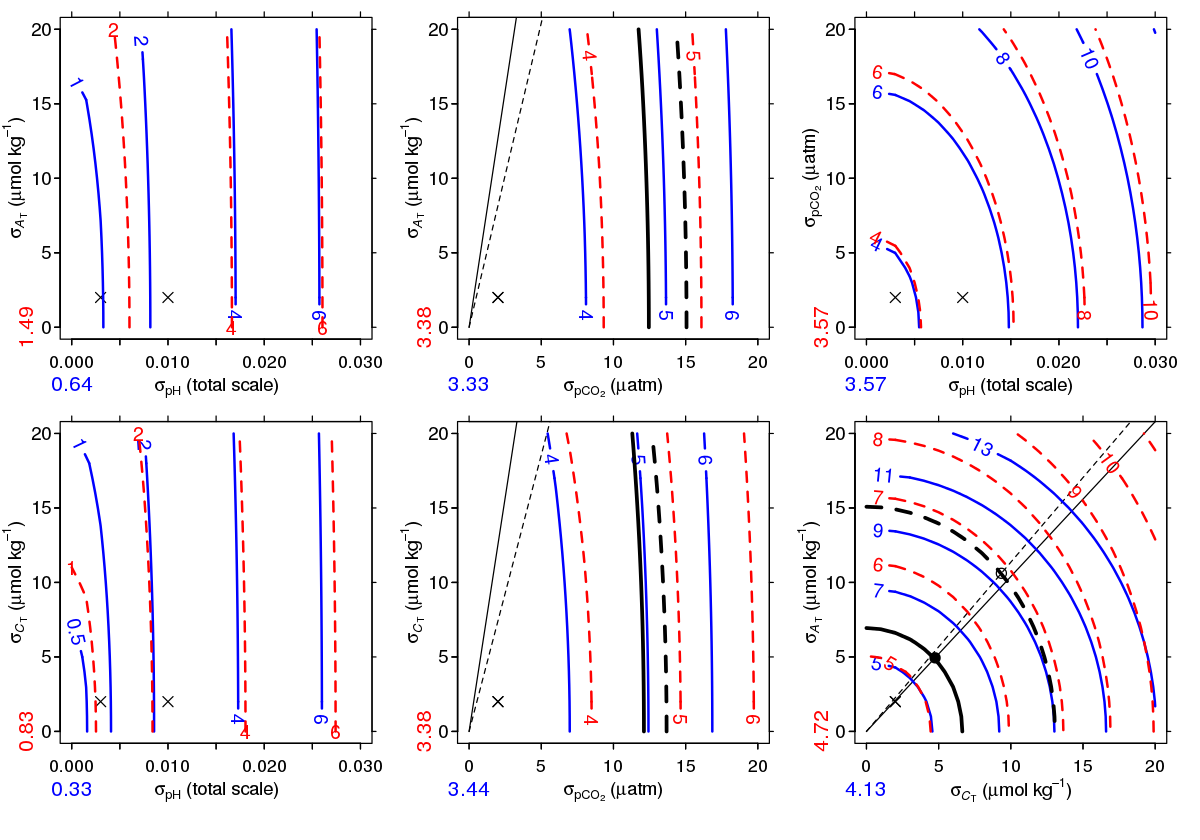

In [92]:
# Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_HCO3H.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rHCO3Hsocn) <- c(length(DIC_e), length(ALK_e))
    dim(rHCO3Htrop) <- c(length(DIC_e), length(ALK_e))

    dim(rHCO3H_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rHCO3H_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rHCO3H_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rHCO3H_pHCt_trop) <- c(length(pH_e), length(DIC_e))

    dim(rHCO3H_pCO2pH_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rHCO3H_pCO2pH_trop) <- c(length(pCO2_e), length(pH_e))

    dim(rHCO3H_pCO2At_socn) <- c(length(pCO2_e), length(ALK_e))
    dim(rHCO3H_pCO2At_trop) <- c(length(pCO2_e), length(ALK_e))

    dim(rHCO3H_pCO2Ct_socn) <- c(length(pCO2_e), length(DIC_e))
    dim(rHCO3H_pCO2Ct_trop) <- c(length(pCO2_e), length(DIC_e))

#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$HCO3H ;  sigcritYa <- sig2_pHAt_socn$HCO3H
    sigcritXb <- sig1_pHAt_trop$HCO3H ;  sigcritYb <- sig2_pHAt_trop$HCO3H
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rHCO3H_pHAt_socn   ;  zb <- rHCO3H_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(0.5, 1, seq(0,20,by=2))   ;  levels2 <- levels1

     plterrcontourB (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                     sigcritXb, sigcritYb, 
                     pH_e_soa2, ALK_e_soa2,
                     x, y, za, levels1,
                           zb, levels2,
                     'edge','simple')

#   2. pCO2-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2At_socn$HCO3H  ;  sigcritYa <- sig2_pCO2At_socn$HCO3H 
    sigcritXb <- sig1_pCO2At_trop$HCO3H  ;  sigcritYb <- sig2_pCO2At_trop$HCO3H 
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- pCO2_e ; y <- ALK_e*1e+6  
    za <- rHCO3H_pCO2At_socn   ;  zb <- rHCO3H_pCO2At_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(2.2, 2.5, seq(0,20,by=1))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   hp1_pCO2At_socn_HCO3H, hp2_pCO2At_socn_HCO3H,
                   hp1_pCO2At_trop_HCO3H, hp2_pCO2At_trop_HCO3H,
                   c(0, 10*hp1_pCO2At_socn_HCO3H), c(0, 10*hp2_pCO2At_socn_HCO3H),
                   c(0, 10*hp1_pCO2At_trop_HCO3H), c(0, 10*hp2_pCO2At_trop_HCO3H),
                   pCO2_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'flattest')
    cat('pCO2-Ct (socn): xcrit, ycrit =   ', hp1_pCO2At_socn_HCO3H, hp2_pCO2At_socn_HCO3H, '\n')
    cat('pCO2-Ct (trop): xcrit, ycrit =   ', hp1_pCO2At_trop_HCO3H, hp2_pCO2At_trop_HCO3H, '\n')

#   Because the errhalf routine does not quite work correctly for the HCO3/H ratio,
#   add a contour for the critical curve based on the value of the sigy 
#   Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
    rHCO3 <- sigy_pCO2At_socn[1,]$HCO3/vars_pCO2At_socn[1,]$HCO3
    rH    <- sigy_pCO2At_socn[1,]$H   /vars_pCO2At_socn[1,]$H
    rHCO3Hhalf_socn <- sqrt( rHCO3^2 + rH^2 ) * 100
    rHCO3 <- sigy_pCO2At_trop[1,]$HCO3/vars_pCO2At_trop[1,]$HCO3
    rH    <- sigy_pCO2At_trop[1,]$H   /vars_pCO2At_trop[1,]$H
    rHCO3Hhalf_trop <- sqrt( rHCO3^2 + rH^2 ) * 100
    contour(x, y , za, levels=rHCO3Hhalf_socn, method='flattest', col="black", lty=1, lwd=3, 
            yaxt='n', drawlabels=FALSE, add=TRUE)
    contour(x, y , zb, levels=rHCO3Hhalf_trop, col="black", lty=2, lwd=3, 
             yaxt='n', drawlabels=FALSE, add=TRUE)

#   3. pCO2-pH
#   ------------------------
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))

#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_pCO2pH_socn$HCO3H  ;  sigcritYa <- sig1_pCO2pH_socn$HCO3H
    sigcritXb <- sig2_pCO2pH_trop$HCO3H  ;  sigcritYb <- sig1_pCO2pH_trop$HCO3H
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- pH_e  ;  y <- pCO2_e
    za <- t(rHCO3H_pCO2pH_socn)  ;  zb <- t(rHCO3H_pCO2pH_trop)
    xlim <- c(0,0.03)  ; ylim <- c(0,20)
    levels1 <- c(2.5, 3, seq(0,20,by=2))  ;  levels2 <- levels1
    plterrcontourB (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                    sigcritXb, sigcritYb, 
                    pH_e_soa2, pCO2_e_soa2,
                    x, y, za, levels1,
                          zb, levels2)

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$HCO3H  ;  sigcritYa <- sig2_pHCt_socn$HCO3H
    sigcritXb <- sig1_pHCt_trop$HCO3H  ;  sigcritYb <- sig2_pHCt_trop$HCO3H
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rHCO3H_pHCt_socn   ;  zb <- rHCO3H_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(0.5, 1, seq(0,20,by=2))   ;  levels2 <- levels1
    plterrcontourB (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                    sigcritXb, sigcritYb, 
                    pH_e_soa2, DIC_e_soa2,
                    x, y, za, levels1,
                          zb, levels2,
                    'edge', 'simple')

#   5. pCO2-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pCO[2]]," (",mu,"atm",")",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pCO2Ct_socn$HCO3H ;  sigcritYa <- sig2_pCO2Ct_socn$HCO3H
    sigcritXb <- sig1_pCO2Ct_trop$HCO3H ;  sigcritYb <- sig2_pCO2Ct_trop$HCO3H
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- pCO2_e ; y <- DIC_e*1e+6  
    za <- rHCO3H_pCO2Ct_socn  ;  zb <- rHCO3H_pCO2Ct_trop 
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(2.3, 2.5, seq(2,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   hp1_pCO2Ct_socn_HCO3H, hp2_pCO2Ct_socn_HCO3H,
                   hp1_pCO2Ct_trop_HCO3H, hp2_pCO2Ct_trop_HCO3H,
                   c(0, 10*hp1_pCO2Ct_socn_HCO3H), c(0, 10*hp2_pCO2Ct_socn_HCO3H),
                   c(0, 10*hp1_pCO2Ct_trop_HCO3H), c(0, 10*hp2_pCO2Ct_trop_HCO3H),
                   pCO2_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('pCO2-Ct (socn): xcrit, ycrit =   ', hp1_pCO2Ct_socn_HCO3H, hp2_pCO2Ct_socn_HCO3H, '\n')
    cat('pCO2-Ct (trop): xcrit, ycrit =   ', hp1_pCO2Ct_trop_HCO3H, hp2_pCO2Ct_trop_HCO3H, '\n')

#   Because the errhalf routine does not quite work correctly for the HCO3/H ratio,
#   add a contour for the critical curve based on the value of the sigy 
#   Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
    rHCO3 <- sigy_pCO2Ct_socn[1,]$HCO3/vars_pCO2Ct_socn[1,]$HCO3
    rH    <- sigy_pCO2Ct_socn[1,]$H   /vars_pCO2Ct_socn[1,]$H
    rHCO3Hhalf_socn <- sqrt( rHCO3^2 + rH^2 ) * 100
    rHCO3 <- sigy_pCO2Ct_trop[1,]$HCO3/vars_pCO2Ct_trop[1,]$HCO3
    rH    <- sigy_pCO2Ct_trop[1,]$H   /vars_pCO2Ct_trop[1,]$H
    rHCO3Hhalf_trop <- sqrt( rHCO3^2 + rH^2 ) * 100
    contour(x, y , za, levels=rHCO3Hhalf_socn, method='flattest', col="black", lty=1, lwd=3, 
            yaxt='n', drawlabels=FALSE, add=TRUE)
    contour(x, y , zb, levels=rHCO3Hhalf_trop, col="black", lty=2, lwd=3, 
             yaxt='n', drawlabels=FALSE, add=TRUE)
#   tt <- contourLines(x, y , zb, levels=rHCO3Hhalf_trop)
#   print(tt)
            
#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$H  ;  sigcritYa <- sig1_AtCt_socn$H  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$H  ;  sigcritYb <- sig1_AtCt_trop$H
    sigcritXa <- NULL  ;  sigcritYa <- NULL 
    sigcritXb <- NULL  ;  sigcritYb <- NULL 
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rHCO3Hsocn  ;  zb <- rHCO3Htrop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(0.2, 0.5, by=0.3)  ;  levels2 <- levels1
    levels1 <- c(0.2, seq(2, 20, by=2))  ;  levels2 <- levels1
    levels1 <- seq(3, 14, by=2)  ;  levels2 <- seq(3, 14, by=1)

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   hp2_AtCt_socn_HCO3H, hp1_AtCt_socn_HCO3H,
                   hp2_AtCt_trop_HCO3H, hp1_AtCt_trop_HCO3H,
                   c(0, 10*hp2_AtCt_socn_HCO3H), c(0, 10*hp1_AtCt_socn_HCO3H),
                   c(0, 10*hp2_AtCt_trop_HCO3H), c(0, 10*hp1_AtCt_trop_HCO3H),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'flattest')
    cat('At-Ct (socn): xcrit, ycrit   =     ', hp1_AtCt_socn_HCO3H, hp2_AtCt_socn_HCO3H, '\n')
    cat('At-Ct (trop): xcrit, ycrit   =     ', hp1_AtCt_trop_HCO3H, hp2_AtCt_trop_HCO3H, '\n')


#   Because the errhalf routine does not quite work correctly for the HCO3/H ratio,
#   add a contour for the critical curve based on the value of the sigy 
#   Compute relative errors of HCO3-, H+, ahnd HCO3-/H+
    rHCO3 <- sigy_AtCt_socn[1,]$HCO3/vars_socn[1,]$HCO3
    rH    <- sigy_AtCt_socn[1,]$H   /vars_socn[1,]$H
    rHCO3Hhalf_socn <- sqrt( rHCO3^2 + rH^2 ) * 100
    rHCO3 <- sigy_AtCt_trop[1,]$HCO3/vars_trop[1,]$HCO3
    rH    <- sigy_AtCt_trop[1,]$H / vars_trop[1,]$H
    rHCO3Hhalf_trop <- sqrt( rHCO3^2 + rH^2 ) * 100
    contour(x, y , za, levels=rHCO3Hhalf_socn, method='flattest', col="black", lty=1, lwd=3, 
            yaxt='n', drawlabels=FALSE, add=TRUE)
    contour(x, y , zb, levels=rHCO3Hhalf_trop, col="black", lty=2, lwd=3, 
             yaxt='n', drawlabels=FALSE, add=TRUE)

# Turn off device driver (to flush output to PDF)
#  dev.off()

***Figure:*** Percent relative uncertainty in the computed $[\text{HCO}_3^-] / [\text{H}^+]$ ratio for six input pairs as a function of uncertainties in each pair member. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### 4.3.10 Plot Relative error in pCO2  for 6 input pairs

In [93]:
rpCO2_pCO2pH_socn

NULL

pH-At: xcrit, ycrit =  0.0100155 57.44879 
pH-Ct: xcrit, ycrit =  0.0105253 54.20862 
At-Ct: xcrit, ycrit =    5.184826 5.775632 


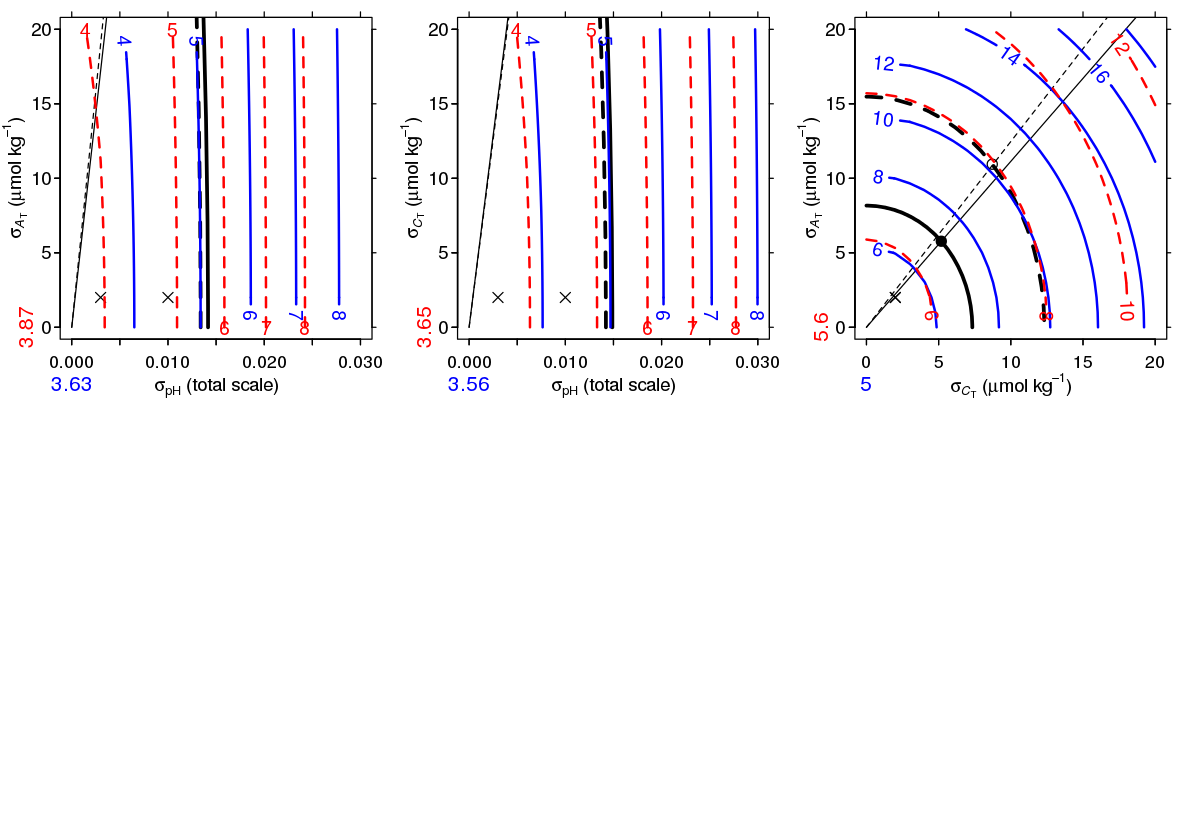

In [94]:
### Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_pCO2_trois.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rpCO2socn) <- c(length(DIC_e), length(ALK_e))
    dim(rpCO2trop) <- c(length(DIC_e), length(ALK_e))

    dim(rpCO2_pHAt_socn) <- c(length(pH_e), length(ALK_e))
    dim(rpCO2_pHAt_trop) <- c(length(pH_e), length(ALK_e))

    dim(rpCO2_pHCt_socn) <- c(length(pH_e), length(DIC_e))
    dim(rpCO2_pHCt_trop) <- c(length(pH_e), length(DIC_e))

#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$pCO2 ;  sigcritYa <- sig2_pHAt_socn$pCO2
    sigcritXb <- sig1_pHAt_trop$pCO2 ;  sigcritYb <- sig2_pHAt_trop$pCO2
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rpCO2_pHAt_socn   ;  zb <- rpCO2_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(0,8,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$pCO2), zenon(sigm2_pHAt_socn$pCO2),
                   zenon(sigm1_pHAt_trop$pCO2), zenon(sigm2_pHAt_trop$pCO2),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pH-At: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   4. pH-Ct
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig1_pHCt_socn$pCO2  ;  sigcritYa <- sig2_pHCt_socn$pCO2
    sigcritXb <- sig1_pHCt_trop$pCO2  ;  sigcritYb <- sig2_pHCt_trop$pCO2
    x <- pH_e  ;  y <- DIC_e*1e+6
    za <- rpCO2_pHCt_socn   ;  zb <- rpCO2_pHCt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(2.5, seq(1,20,by=1))   ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHCt_socn$pCO2), zenon(sigm2_pHCt_socn$pCO2),
                   zenon(sigm1_pHCt_trop$pCO2), zenon(sigm2_pHCt_trop$pCO2),
                   pH_e_soa2, DIC_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')
    cat('pH-Ct: xcrit, ycrit = ', sigcritXa[11], sigcritYa[11], '\n')

#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$pCO2  ;  sigcritYa <- sig1_AtCt_socn$pCO2  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$pCO2  ;  sigcritYb <- sig1_AtCt_trop$pCO2
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rpCO2socn  ;  zb <- rpCO2trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1, 3, seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$pCO2), zenon(sigm1_AtCt_socn$pCO2),
                   zenon(sigm2_AtCt_trop$pCO2), zenon(sigm1_AtCt_trop$pCO2),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')
    cat('At-Ct: xcrit, ycrit =   ', sigcritXa[11], sigcritYa[11], '\n')

# Turn off device driver (to flush output to PDF)
# dev.off()

***Figure:*** Percent relative uncertainty in the computed $p\text{CO}_2$  for three input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.

#### Crop off edges of PDF file

In [97]:
%%bash
filename='Fig_RelErrContours2_trop_socn.pdf'
pdfcrop $filename tmp.pdf
mv tmp.pdf $filename
echo `pwd`/$filename
ls -lt $filename

ERROR: Error in parse(text = x, srcfile = src): <text>:1:1: unexpected SPECIAL
1: %%
    ^
